## Intro: 
- The notebook will process ADCP, ERA5 shortwave radiation, OSISAF ice concentration and 1D GOTM-ECOSMO model output for data (PAR & food) below the surface as input for machine learning algoritm.
- The post-processed data is a 7-day averaged 24-hour period time series data that has surface light, day-length, integrated food for mesozooplankton, PAR below surface.
- Then a decision tree approach is used with these input time-series data to estimate the PAR values corresponding to the upper and lower boundary of high migrating organism concentration and its diurnal variation over seasons.
- The final PAR values and their predictors are expected to be coded in biogeochemical models for use during simulations.
### Libraries and functions

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import datetime
import matplotlib.dates as mdates
import pandas as pd
import netCDF4
from netCDF4 import Dataset as NetCDFFile
plt.style.use('seaborn-v0_8-notebook')
cmap = plt.get_cmap('Spectral_r')
diff = plt.get_cmap('RdYlBu_r')
from matplotlib.colors import BoundaryNorm
import pickle
from scipy import interpolate
import scipy.io
import modelinput
import os 
import math
import cftime
from scipy.interpolate import interp1d

def running_mean(arr, N):
    arr_masked = np.ma.array(arr, mask=np.isnan(arr))
    cumsum = np.ma.cumsum(np.insert(arr_masked, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def bilinear_interpolation(x, y, points, values):
    # Sort the points by x, then by y
    points = sorted(points)
    x_points = sorted(set(point[0] for point in points))
    y_points = sorted(set(point[1] for point in points))
    
    # Find the corners of the cell that (x, y) is in
    x0 = max([xp for xp in x_points if xp <= x])
    x1 = min([xp for xp in x_points if xp >= x])
    y0 = max([yp for yp in y_points if yp <= y])
    y1 = min([yp for yp in y_points if yp >= y])
    
    # Extract the values at the corners
    Q11 = values[y_points.index(y0), x_points.index(x0)]
    Q12 = values[y_points.index(y1), x_points.index(x0)]
    Q21 = values[y_points.index(y0), x_points.index(x1)]
    Q22 = values[y_points.index(y1), x_points.index(x1)]
    
    # Perform the interpolation
    return (Q11 * (x1 - x) * (y1 - y) +
            Q21 * (x - x0) * (y1 - y) +
            Q12 * (x1 - x) * (y - y0) +
            Q22 * (x - x0) * (y - y0)
           ) / ((x1 - x0) * (y1 - y0))

def calculate_day_length(latitude, yearday):
    # Convert latitude to radians
    latitude = latitude * math.pi / 180.0   
    # Calculate declination
    declination = 23.44 * math.pi / 180.0 * math.sin(2.0 * math.pi / 365.0 * (yearday - 81.0))
    # Calculate inside_acos value
    inside_acos = max(-1.0, min(1.0, -math.tan(latitude) * math.tan(declination)))
    # Calculate day length
    day_length = 24.0 / math.pi * math.acos(inside_acos)
    # Ensure day length is within the range [0, 24]
    day_length = max(0.0, min(24.0, day_length))
    return day_length

## Item - 1: Post-process ADCP and surface data as input for machine learning algorithm
### data description

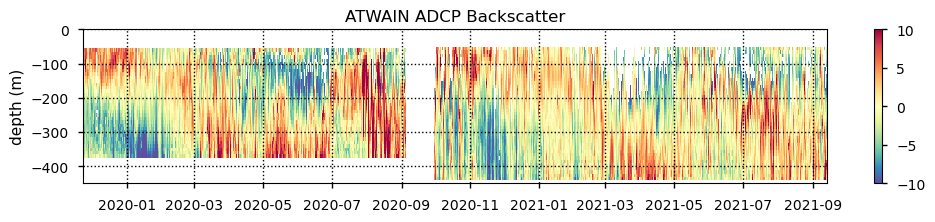

In [2]:
mat = scipy.io.loadmat('Avg.VTC.DSEL.AVER_2019-2020_ATWAIN.mat')
avg_data = mat['Avg_Data\x00\x00\x00\x00\x00\x00\x00\x00']
amp1 = avg_data['BinMapAmpBeam1'][0,0]
amp2 = avg_data['BinMapAmpBeam2'][0,0]
amp3 = avg_data['BinMapAmpBeam3'][0,0]
amp4 = avg_data['BinMapAmpBeam4'][0,0]
amp = (amp1 + amp2 + amp3 + amp4)/4.
amp[0:12,:] = np.nan
amp = np.ma.masked_invalid(amp)
masked = avg_data['DataMask'][0,0]
amp = np.ma.masked_where(masked != 0.0, amp)
m, n = amp.shape
for d in range(m):
    try:
        a = np.nanmean(amp[d,:])
        amp[d,:] = amp[d,:] - a
    except:
        pass
ATW1 = np.copy(amp)
ATW1 = np.ma.masked_where(masked != 0.0, ATW1)

ATW1_depth = avg_data['Depth'][0,0][0,:]
matlab_datenum = avg_data['TimeMatlab'][0,0][0,:]
ATW1_datetime = [datetime.datetime.fromordinal(int(t)) + datetime.timedelta(days=float(t)%1) - datetime.timedelta(days = 366) for t in matlab_datenum]


mat = scipy.io.loadmat('Avg.VTC.DSEL.AVER_2020-2021_ATWAIN.mat')
avg_data = mat['Avg_Data\x00\x00\x00\x00\x00\x00\x00\x00']

amp1 = avg_data['BinMapAmpBeam1'][0,0]
amp2 = avg_data['BinMapAmpBeam2'][0,0]
amp3 = avg_data['BinMapAmpBeam3'][0,0]
amp4 = avg_data['BinMapAmpBeam4'][0,0]
amp = (amp1 + amp2 + amp3 + amp4)/4.
amp[0:6,:] = np.nan
amp = np.ma.masked_invalid(amp)
masked = avg_data['DataMask'][0,0]
amp = np.ma.masked_where(masked != 0.0, amp)


m, n = amp.shape
for d in range(m):
    try:
        a = np.nanmean(amp[d,:])
        amp[d,:] = amp[d,:] - a
    except:
        pass
ATW2 = np.copy(amp)
ATW2 = np.ma.masked_where(masked != 0.0, ATW2)


ATW2_depth = avg_data['Depth'][0,0][0,:]
matlab_datenum = avg_data['TimeMatlab'][0,0][0,:]
ATW2_datetime = [datetime.datetime.fromordinal(int(t)) + datetime.timedelta(days=float(t)%1) - datetime.timedelta(days = 366) for t in matlab_datenum]

fig, (ax1)  = plt.subplots(1,sharex=True, figsize=(12,2),facecolor="w")
ampmin = -10 #np.nanmin([ATW1.min(),ATW2.min()])
ampmax = 10 #np.nanmax([ATW1.max(),ATW2.max()])
pATW1 = ax1.pcolormesh(ATW1_datetime,-ATW1_depth,ATW1,cmap=cmap)
pATW2 = ax1.pcolormesh(ATW2_datetime,-ATW2_depth,ATW2,cmap=cmap)
pATW1.set_clim(ampmin,ampmax)
pATW2.set_clim(ampmin,ampmax)
ax1.set_title('ATWAIN ADCP Backscatter')
ax1.set_ylim(-450,0)
ax1.set_ylabel('depth (m)')
plt.colorbar(pATW1)
ax1.grid(True, linestyle=':', color='black')
plt.xlim(ATW1_datetime[0],ATW2_datetime[-1]);


### The code will run at the ATWAIN mooring station in the Barents Sea (81.55N 30.83E). It is a seasonally ice covered station.

### Load osisaf ice concentration from thredds server. Takes around 5 minutes. The code below will save the ice data, therefore once this is executed, the lines indicated can be commented out, and simply load ice concentration from the saved netcdf file. For convenience, ice.pckl data is included in this repository. The commented out code is presented here for documenting the process to create ice data.

In [4]:
# comment out below

#nc = NetCDFFile('https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/amsr2_conc_nh_pol_agg')
#icelat   = nc.variables['lat'][:,:]
#icelon   = nc.variables['lon'][:,:]
#icetimed = nc.variables['time']
#icetime  = netCDF4.num2date(icetimed[:], units=icetimed.units)
#
#cooINDEX = abs( icelat-81.55 ) + abs( icelon-30.83 )
#JJ,II = np.unravel_index(cooINDEX.argmin(), cooINDEX.shape)
#iceATW = nc.variables['ice_conc'][:,JJ,II]
#
#fice = open('ice.pckl','wb')
#pickle.dump([icetime,iceATW],fice)
#fice.close()

# comment out above

fice = open('ice.pckl','rb')
icetime,iceATW = pickle.load(fice)
fice.close()

### Below loads a preprepared (a text file) 6-hour interval "Mean surface downward short-wave radiation flux" variables obtained from ERA5 database interpolated to ATWAIN station. It interpolates to colocate the dates of shortwave radiation and ice concentration, and applies the ice concentration correction on shortwave radiation. It also calculates day-length in hours. Saves it for later use. This 6h shortwave radiation is the same data we use for the 3D HYCOM coupled ECOSMO for the hindcast simulations.

In [5]:
# Combine date and value arrays into a list of tuples
ice_combined_data = list(zip(icetime.data.tolist(), iceATW.tolist()))

# Read the file and extract date and value
def read_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            date_str = ' '.join(parts[:2])  # Combine the first two parts for the date
            value_str = parts[2]            # The third part is the value
            date = datetime.datetime.strptime(date_str, '%Y-%m-%d %H:%M:%S')
            value = float(value_str)
            data.append((date, value))
    return data


file_path = 'ssr.hycom.spinup.dat'
file_data = read_file(file_path)

# Extract dates and values from the file data
ssr_hycom_dates_ATW = [entry[0] for entry in file_data]
ssr_hycom_values_ATW = [entry[1] for entry in file_data]

date_nums = np.array([date.timestamp() for date in ssr_hycom_dates_ATW])
# Create an array of new dates with 1-hour intervals
start_date = ssr_hycom_dates_ATW[0]
end_date = ssr_hycom_dates_ATW[-1]
new_dates = [start_date + datetime.timedelta(hours=i) for i in range(int((end_date - start_date).total_seconds() / 3600) + 1)]

# Convert new dates to numerical format
new_date_nums = np.array([date.timestamp() for date in new_dates])

# Interpolate values to the new dates
interpolator = interp1d(date_nums, ssr_hycom_values_ATW)
new_values = interpolator(new_date_nums)

ssr_hycom_dates_ATW = new_dates
ssr_hycom_values_ATW = new_values

dates1 = [datetime.datetime(idate.year, idate.month, idate.day) for idate in icetime]
dates1_float = (np.array(dates1) - datetime.datetime(1990,1,1)).astype('timedelta64[D]').astype(float)
dates2_float = (np.array(ssr_hycom_dates_ATW) - datetime.datetime(1990,1,1)).astype('timedelta64[D]').astype(float)
ice_interpolated = np.interp(dates2_float,dates1_float,iceATW)

ice_corrected_hycom_ssr_ATW = []
dlATW = []
with open('ssr_hycom6h_ice_corrected_cap99.dat','w') as f:
     for t in range(len(ssr_hycom_dates_ATW)):
         day_number = ssr_hycom_dates_ATW[t].timetuple().tm_yday
         dlATW.append(calculate_day_length(81.55, day_number))
         capped = np.max([0.0,ssr_hycom_values_ATW[t] * (1.0 - np.min([ice_interpolated[t],99.0]) / 100.)] )
         ice_corrected_hycom_ssr_ATW.append(capped)
         f.write('{}\t{:.8f}\t{}\n'.format(str(ssr_hycom_dates_ATW[t]),capped,str(ice_interpolated[t])))

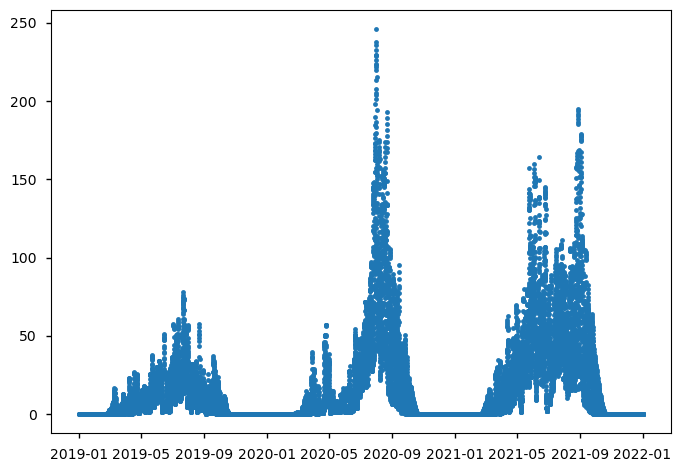

In [6]:
plt.plot(ssr_hycom_dates_ATW,ice_corrected_hycom_ssr_ATW,'.')

### The code below does a 7-day averaging for each hour (e.g. hour=00:00 - 01:00, hour=01:00 - 02:00) over the ADCP period in ATWAIN station. Data processed is backscatter anomally, shortwave radiation, day-length, and ice concentration.

In [7]:
averaging_days = 7

In [8]:
# time averaging ATWAIN
import datetime

tssATW1 = []
tssssrATW1 = []
tssiceATW1 = []
tssdlATW1 = []
#tssHeimATW1 = []

for d in range(len(ATW1[:,0])):
    start_date = ATW1_datetime[0]
    end_date = ATW1_datetime[-1]
    start_week = start_date
    weekly_averages_ATW1 = []
    weekly_averages_ssrATW1 = []
    weekly_averages_iceATW1 = []
    weekly_averages_dlATW1 = []
    # weekly_averages_ATW1heimdall = []
    # weekly_averages_ATW1heimdall_below = []

    while start_week < end_date:
        end_week = start_week + datetime.timedelta(days=averaging_days)
        weekly_ATW1 = [ATW1[d,i] for i in range(len(ATW1_datetime)) if start_week <= ATW1_datetime[i] < end_week]
        weekly_dateATW1 = [ATW1_datetime[i] for i in range(len(ATW1_datetime)) if start_week <= ATW1_datetime[i] < end_week]
        hourly_averages_ATW1 = []
        hourly_averages_velATW1 = []

        if d == 0:
            weekly_ssrATW1 = [ice_corrected_hycom_ssr_ATW[i] for i in range(len(ssr_hycom_dates_ATW)) if start_week <= ssr_hycom_dates_ATW[i] < end_week]
            weekly_date_ssrATW1 = [ssr_hycom_dates_ATW[i] for i in range(len(ssr_hycom_dates_ATW)) if start_week <= ssr_hycom_dates_ATW[i] < end_week]
            hourly_averages_ssrATW1 = []

            weekly_iceATW1 = [iceATW[i] for i in range(len(icetime)) if start_week <= icetime[i] < end_week]
            weekly_date_iceATW1 = [icetime[i] for i in range(len(icetime)) if start_week <= icetime[i] < end_week]
            hourly_averages_iceATW1 = []

            weekly_dlATW1 = [dlATW[i] for i in range(len(ssr_hycom_dates_ATW)) if start_week <= ssr_hycom_dates_ATW[i] < end_week]
            weekly_date_dlATW1 = [ssr_hycom_dates_ATW[i] for i in range(len(ssr_hycom_dates_ATW)) if start_week <= ssr_hycom_dates_ATW[i] < end_week]
            hourly_averages_dlATW1 = []


        for hour in range(24):
            # Get the data for the current hour
            hourly_data = [weekly_ATW1[i] for i in range(len(weekly_dateATW1)) if weekly_dateATW1[i].hour == hour]
            if hourly_data:  # Check if the list is not empty
                hourly_average = np.nanmean(hourly_data) #sum(hourly_data) / len(hourly_data)
                hourly_averages_ATW1.append(hourly_average)
            else:
                hourly_averages_ATW1.append(None)  # Append None if there is no data for the current hour

            if d == 0:
                hourly_data_ssr = [weekly_ssrATW1[i] for i in range(len(weekly_date_ssrATW1)) if weekly_date_ssrATW1[i].hour == hour]
                if hourly_data_ssr:  # Check if the list is not empty
                    hourly_average_ssr = np.nanmean(hourly_data_ssr)
                    hourly_averages_ssrATW1.append(hourly_average_ssr)
                else:
                    hourly_averages_ssrATW1.append(None)  # Append None if there is no data for the current hour

                hourly_data_ice = [weekly_iceATW1[i] for i in range(len(weekly_date_iceATW1)) if weekly_date_iceATW1[i].hour == hour]
                if hourly_data_ice:  # Check if the list is not empty
                    hourly_average_ice = np.nanmean(hourly_data_ice)
                    hourly_averages_iceATW1.append(hourly_average_ice)
                else:
                    hourly_averages_iceATW1.append(None)  # Append None if there is no data for the current hour

                hourly_data_dl = [weekly_dlATW1[i] for i in range(len(weekly_date_dlATW1)) if weekly_date_dlATW1[i].hour == hour]
                if hourly_data_dl:  # Check if the list is not empty
                    hourly_average_dl = np.nanmean(hourly_data_dl)
                    hourly_averages_dlATW1.append(hourly_average_dl)
                else:
                    hourly_averages_dlATW1.append(None)  # Append None if there is no data for the current hour


        weekly_averages_ATW1.append(hourly_averages_ATW1)
        if d == 0:
            weekly_averages_ssrATW1.append(hourly_averages_ssrATW1)
            weekly_averages_iceATW1.append(hourly_averages_iceATW1)
            weekly_averages_dlATW1.append(hourly_averages_dlATW1)
        start_week = end_week

    tssATW1.append( np.array(weekly_averages_ATW1).reshape(-1) )
    if d == 0: 
        tssssrATW1 = ( np.array(weekly_averages_ssrATW1).reshape(-1) )
        tssiceATW1 = ( np.array(weekly_averages_iceATW1).reshape(-1) )
        tssdlATW1 = ( np.array(weekly_averages_dlATW1).reshape(-1) )

aveATW1 = np.vstack(tssATW1)
avessrATW1 = np.vstack(tssssrATW1)
aveiceATW1 = np.vstack(tssiceATW1)
avedlATW1 = np.vstack(tssdlATW1)

tssATW2 = []
tssvelATW2 = []
tssssrATW2 = []
tssiceATW2 = []
tssdlATW2 = []

for d in range(len(ATW2[:,0])):
    start_date = ATW2_datetime[0]
    end_date = ATW2_datetime[-1]
    start_week = start_date
    weekly_averages_ATW2 = []
    weekly_averages_velATW2 = []
    weekly_averages_ssrATW2 = []
    weekly_averages_iceATW2 = []
    weekly_averages_dlATW2 = []

    while start_week < end_date:
        end_week = start_week + datetime.timedelta(days=averaging_days)
        weekly_ATW2 = [ATW2[d,i] for i in range(len(ATW2_datetime)) if start_week <= ATW2_datetime[i] < end_week]
        weekly_dateATW2 = [ATW2_datetime[i] for i in range(len(ATW2_datetime)) if start_week <= ATW2_datetime[i] < end_week]
        hourly_averages_ATW2 = []
        hourly_averages_velATW2 = []

        if d == 0:
            weekly_ssrATW2 = [ice_corrected_hycom_ssr_ATW[i] for i in range(len(ssr_hycom_dates_ATW)) if start_week <= ssr_hycom_dates_ATW[i] < end_week]
            weekly_date_ssrATW2 = [ssr_hycom_dates_ATW[i] for i in range(len(ssr_hycom_dates_ATW)) if start_week <= ssr_hycom_dates_ATW[i] < end_week]
            hourly_averages_ssrATW2 = []

            weekly_iceATW2 = [iceATW[i] for i in range(len(icetime)) if start_week <= icetime[i] < end_week]
            weekly_date_iceATW2 = [icetime[i] for i in range(len(icetime)) if start_week <= icetime[i] < end_week]
            hourly_averages_iceATW2 = []

            weekly_dlATW2 = [dlATW[i] for i in range(len(ssr_hycom_dates_ATW)) if start_week <= ssr_hycom_dates_ATW[i] < end_week]
            weekly_date_dlATW2 = [ssr_hycom_dates_ATW[i] for i in range(len(ssr_hycom_dates_ATW)) if start_week <= ssr_hycom_dates_ATW[i] < end_week]
            hourly_averages_dlATW2 = []

        for hour in range(24):
            # Get the data for the current hour
            hourly_data = [weekly_ATW2[i] for i in range(len(weekly_dateATW2)) if weekly_dateATW2[i].hour == hour]
            if hourly_data:  # Check if the list is not empty
                hourly_average = np.nanmean(hourly_data) #sum(hourly_data) / len(hourly_data)
                hourly_averages_ATW2.append(hourly_average)
            else:
                hourly_averages_ATW2.append(None)  # Append None if there is no data for the current hour

            if d == 0:
                hourly_data_ssr = [weekly_ssrATW2[i] for i in range(len(weekly_date_ssrATW2)) if weekly_date_ssrATW2[i].hour == hour]
                if hourly_data_ssr:  # Check if the list is not empty
                    hourly_average_ssr = np.nanmean(hourly_data_ssr)
                    hourly_averages_ssrATW2.append(hourly_average_ssr)
                else:
                    hourly_averages_ssrATW2.append(None)  # Append None if there is no data for the current hour

                hourly_data_ice = [weekly_iceATW2[i] for i in range(len(weekly_date_iceATW2)) if weekly_date_iceATW2[i].hour == hour]
                if hourly_data_ice:  # Check if the list is not empty
                    hourly_average_ice = np.nanmean(hourly_data_ice)
                    hourly_averages_iceATW2.append(hourly_average_ice)
                else:
                    hourly_averages_iceATW2.append(None)  # Append None if there is no data for the current hour

                hourly_data_dl = [weekly_dlATW2[i] for i in range(len(weekly_date_dlATW2)) if weekly_date_dlATW2[i].hour == hour]
                if hourly_data_dl:  # Check if the list is not empty
                    hourly_average_dl = np.nanmean(hourly_data_dl)
                    hourly_averages_dlATW2.append(hourly_average_dl)
                else:
                    hourly_averages_dlATW2.append(None)  # Append None if there is no data for the current hour

        weekly_averages_ATW2.append(hourly_averages_ATW2)
        if d == 0:
            weekly_averages_ssrATW2.append(hourly_averages_ssrATW2)
            weekly_averages_iceATW2.append(hourly_averages_iceATW2)
            weekly_averages_dlATW2.append(hourly_averages_dlATW2)
        start_week = end_week
    tssATW2.append( np.array(weekly_averages_ATW2).reshape(-1) )
    tssvelATW2.append( np.array(weekly_averages_velATW2).reshape(-1) )
    if d == 0: 
        tssssrATW2 = ( np.array(weekly_averages_ssrATW2).reshape(-1) )
        tssiceATW2 = ( np.array(weekly_averages_iceATW2).reshape(-1) )
        tssdlATW2 = ( np.array(weekly_averages_dlATW2).reshape(-1) )

aveATW2 = np.vstack(tssATW2)
avessrATW2 = np.vstack(tssssrATW2)
aveiceATW2 = np.vstack(tssiceATW2)
avedlATW2 = np.vstack(tssdlATW2)



## Item - 2: Post-process 1D GOTM-ECOSMO model output for use as input to machine learning algorithm similar to ADCP and surface data.
### The purpose here is to produce a 1D lower trophic level biogeochemistry at ATWAIN station to produce below surface PAR & food as input to machince learning algorithm. 
### To increase the accuracy of the 1D model, it is nudged towards the ARCTIC reanalysis model T and S data. Code below retrieves Temperature and Salinity at ATWAIN station for the sampling duration, interpolates it and saves them as ATWAIN_hycom_temp.dat and ATWAIN_hycom_sal.dat. The ARC_reanalysis file is large and can be retrieved here: . For convenience, ATWAIN_hycom_temp.dat and ATWAIN_hycom_sal.dat files are included in this repository. **There is no need to run this, but it is provided here for documenting the data creation process**. 

In [25]:
# HYCOM reanalysis
# If you have the model output files (.dat), do not run it
nc = NetCDFFile('ARC_reanalysis.nc')
print(nc.variables.keys())
nctime = nc.variables['time']
HYCOMtime = netCDF4.num2date(nctime[:], units=nctime.units)

lat = nc.variables['latitude'][:]
lon = nc.variables['longitude'][:]
d   = np.abs(nc.variables['depth'][:])*(-1.0)

# ATWAIN
JJ = np.argmin( np.abs( lat-81.57 )) # modified lat from 81.55 to 81.57 to get the appropriate depth from hycom
II = np.argmin( np.abs( lon-30.83 ))
print(JJ,II)
tATW = nc.variables['thetao'][:,:,JJ,II]
sATW = nc.variables['so'][:,:,JJ,II]
#iATW = nc.variables['siconc'][:,JJ,II]

#dates1 = [datetime.datetime(idate.year, idate.month, idate.day) for idate in HYCOMtime]
#dates1_float = (np.array(dates1) - datetime.datetime(1990,1,1)).astype('timedelta64[D]').astype(float)
#dates2_float = (np.array(era5time) - datetime.datetime(1990,1,1)).astype('timedelta64[D]').astype(float)

#HYCOM_ice_interpolated_ATW = np.interp(dates2_float,dates1_float,iATW)

with open('ATWAIN_hycom_temp.dat','w') as f:
    for t in range(len(HYCOMtime)):
        nlines = len(d)-1
        time_modified = datetime.datetime(HYCOMtime[t].year,HYCOMtime[t].month,HYCOMtime[t].day,0,0,0)
        f.write('{} {} {}'.format(str(time_modified),str(nlines),'2\n'))
        for l in range(len(d)-2):
            #if not np.ma.is_masked(tATW[t,l]): 
            f.write('{} {}'.format(str(d[l]),str(tATW[t,l])+'\n'))
        f.write('{} {}'.format(str(d[l+1]),str(tATW[t,l])+'\n'))
f.close()
with open('ATWAIN_hycom_sal.dat','w') as f:
    for t in range(len(HYCOMtime)):
        nlines = len(d)-1
        time_modified = datetime.datetime(HYCOMtime[t].year,HYCOMtime[t].month,HYCOMtime[t].day,0,0,0)
        f.write('{} {} {}'.format(str(time_modified),str(nlines),'2\n'))
        for l in range(len(d)-2):
            #if not np.ma.is_masked(sATW[t,l]): 
            f.write('{} {}'.format(str(d[l]),str(sATW[t,l])+'\n'))
        f.write('{} {}'.format(str(d[l+1]),str(sATW[t,l])+'\n'))
f.close()

dict_keys(['depth', 'latitude', 'longitude', 'mlotst', 'siconc', 'so', 'thetao', 'time'])
41 27


### We utilize the 1D GOTM-ECOSMO model output. For convenience, the GOTM model outputs are included in the repository as zipped individual files. Unzip them before running the scripts below. The model folder that produces these outputs are included in the zipped file: **Model_ATWAIN.zip**. For the purposes of ML activity, working with the model files themselves are not necessary. They are included for documentation purposes. 

In [12]:
# Read ATWAIN GOTM model forced by HYCOM reanalysis
# this works in ADANA
os.environ["gotmout"] = os.getcwd()+"/"
# this works in FRAM
# os.environ["gotmout"] = "/cluster/work/users/cagyum/NECCTON/ML/Model_ATWAIN/"
print(os.environ["gotmout"])
#mnc  = modelinput.read('ATWAIN.ice.corrected.afterML')
#mnc  = modelinput.read('GOTM')
mnc  = modelinput.read('model.ATWAIN.xy')
md   = modelinput.getvar(mnc,"depth")
mt   = modelinput.getvar(mnc,"date")
mnc  = modelinput.read('model.ATWAIN.PAR')
mlig = modelinput.getvar(mnc,'light_par')
mnc  = modelinput.read('model.ATWAIN.MIG')
mmig = modelinput.getvar(mnc,'migrator_c')
mnc  = modelinput.read('model.ATWAIN.DIA')
dia = modelinput.getvar(mnc,'ECO_dia')
mnc  = modelinput.read('model.ATWAIN.FLA')
fla = modelinput.getvar(mnc,'ECO_fla')
mnc  = modelinput.read('model.ATWAIN.CCL')
ccl = modelinput.getvar(mnc,'ECO_ccl')
mnc  = modelinput.read('model.ATWAIN.ZOO')
micr = modelinput.getvar(mnc,'ECO_microzoo') 
mfood = dia + fla + ccl + micr

plotdate = []
for tt in range(len(mt)):
    plotdate.append( datetime.datetime( mt[tt].year, mt[tt].month , mt[tt].day, mt[tt].hour, 0, 0) )

/Users/cagyum/Library/CloudStorage/OneDrive-NERSC/Desktop/git_stuff/DVM/


### The codes below does a 7-day averaging for each hour (e.g. hour=00:00 - 01:00, hour=01:00 - 02:00) over the ADCP period in ATWAIN station. Data processed is model output. There are 2 periods extracted corresponding to the two ADCP period processed above. Plots are modelled PAR.

(-400.0, 0.0)

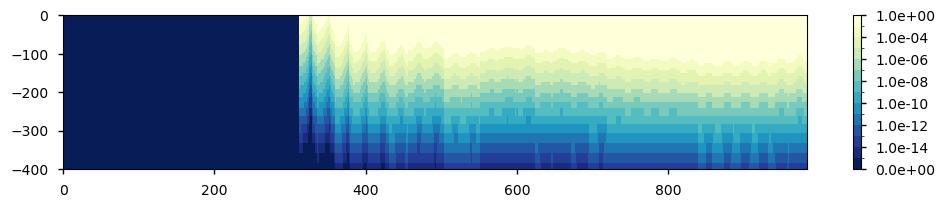

In [13]:
# gotm averaging ATWAIN 1
tssModLATW1 = []
tssModMATW1 = []
tssModFATW1 = []
for d in range(len(md[0,:])):
    start_date = ATW1_datetime[0] #plotdate[0]
    end_date = ATW1_datetime[-1] #plotdate[-1]
    start_week = start_date
    weekly_averages_ModLATW1 = [] 
    weekly_averages_ModMATW1 = []
    weekly_averages_ModFATW1 = []
    while start_week < end_date:
        end_week = start_week + datetime.timedelta(days=averaging_days)
        weekly_ModLATW1 = [mlig[i,d] for i in range(len(plotdate)) if start_week <= plotdate[i] < end_week]
        weekly_dateModLATW1 = [plotdate[i] for i in range(len(plotdate)) if start_week <= plotdate[i] < end_week]   
        hourly_averages_ModLATW1 = []
        weekly_ModMATW1 = [mmig[i,d] for i in range(len(plotdate)) if start_week <= plotdate[i] < end_week]
        weekly_ModFATW1 = [mfood[i,d] for i in range(len(plotdate)) if start_week <= plotdate[i] < end_week]
        hourly_averages_ModMATW1 = []
        hourly_averages_ModFATW1 = []
        for hour in range(24):
            # Get the data for the current hour
            hourly_data = [weekly_ModLATW1[i] for i in range(len(weekly_dateModLATW1)) if weekly_dateModLATW1[i].hour == hour]
            if hourly_data:  # Check if the list is not empty
                hourly_average = np.nanmean(hourly_data) #sum(hourly_data) / len(hourly_data)
                hourly_averages_ModLATW1.append(hourly_average)
            else:
                hourly_averages_ModLATW1.append(-1E20)  # Append None if there is no data for the current hour

            hourly_data = [weekly_ModMATW1[i] for i in range(len(weekly_dateModLATW1)) if weekly_dateModLATW1[i].hour == hour]
            if hourly_data:  # Check if the list is not empty
                hourly_average = np.nanmean(hourly_data) #sum(hourly_data) / len(hourly_data)
                hourly_averages_ModMATW1.append(hourly_average)
            else:
                hourly_averages_ModMATW1.append(-1E20)  # Append None if there is no data for the current hour

            hourly_data = [weekly_ModFATW1[i] for i in range(len(weekly_dateModLATW1)) if weekly_dateModLATW1[i].hour == hour]
            if hourly_data:  # Check if the list is not empty
                hourly_average = np.nanmean(hourly_data) #sum(hourly_data) / len(hourly_data)
                hourly_averages_ModFATW1.append(hourly_average)
            else:
                hourly_averages_ModFATW1.append(-1E20)  # Append None if there is no data for the current hour

        weekly_averages_ModLATW1.append(hourly_averages_ModLATW1)
        weekly_averages_ModMATW1.append(hourly_averages_ModMATW1)
        weekly_averages_ModFATW1.append(hourly_averages_ModFATW1)
        start_week = end_week
    tssModLATW1.append( np.array(weekly_averages_ModLATW1).reshape(-1) ) 
    tssModMATW1.append( np.array(weekly_averages_ModMATW1).reshape(-1) )
    tssModFATW1.append( np.array(weekly_averages_ModFATW1).reshape(-1) )
aveModLATW1 = np.vstack(tssModLATW1)       
aveModLATW1 = np.array(aveModLATW1)
aveModLATW1 = np.ma.masked_where(aveModLATW1<0.0,aveModLATW1)
aveModMATW1 = np.vstack(tssModMATW1)       
aveModMATW1 = np.array(aveModMATW1)
aveModMATW1 = np.ma.masked_where(aveModMATW1<0.0,aveModMATW1)
aveModFATW1 = np.vstack(tssModFATW1)       
aveModFATW1 = np.array(aveModFATW1)
aveModFATW1 = np.ma.masked_where(aveModFATW1<0.0,aveModFATW1)
# plt.pcolormesh(aveModLATW1,cmap=cmap)
# plt.clim(0,0.001)
# plt.colorbar()

levels=np.array([0.,1E-15,1E-14,1E-13,1E-12,1E-11,1E-10,1E-9,1E-8,1E-7,1E-6,1E-5,1E-4,1E-3,1])
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(1,figsize=(12,2))
lmod = ax.pcolormesh(np.arange(aveModLATW1.shape[1]),md[0,:],aveModLATW1,cmap=plt.get_cmap('YlGnBu_r'), norm=norm)
cbar = fig.colorbar(lmod)
formatter = FuncFormatter(lambda x, pos: f'{x:.1e}')
cbar.ax.yaxis.set_major_formatter(formatter)
ax.set_ylim(-400,0)

(-400.0, 0.0)

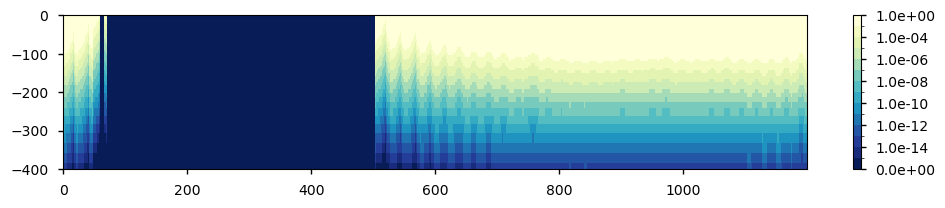

In [14]:
# gotm averaging ATWAIN 2
tssModLATW2 = []
tssModMATW2 = []
tssModFATW2 = []
for d in range(len(md[0,:])):
    start_date = ATW2_datetime[0] #plotdate[0]
    end_date = ATW2_datetime[-1] #plotdate[-1]
    start_week = start_date
    weekly_averages_ModLATW2 = [] 
    weekly_averages_ModMATW2 = []
    weekly_averages_ModFATW2 = []
    while start_week < end_date:
        end_week = start_week + datetime.timedelta(days=averaging_days)
        weekly_ModLATW2 = [mlig[i,d] for i in range(len(plotdate)) if start_week <= plotdate[i] < end_week]
        weekly_dateModLATW2 = [plotdate[i] for i in range(len(plotdate)) if start_week <= plotdate[i] < end_week]   
        hourly_averages_ModLATW2 = []
        weekly_ModMATW2 = [mmig[i,d] for i in range(len(plotdate)) if start_week <= plotdate[i] < end_week]
        weekly_ModFATW2 = [mfood[i,d] for i in range(len(plotdate)) if start_week <= plotdate[i] < end_week]
        hourly_averages_ModMATW2 = []
        hourly_averages_ModFATW2 = []
        for hour in range(24):
            # Get the data for the current hour
            hourly_data = [weekly_ModLATW2[i] for i in range(len(weekly_dateModLATW2)) if weekly_dateModLATW2[i].hour == hour]
            if hourly_data:  # Check if the list is not empty
                hourly_average = np.nanmean(hourly_data) #sum(hourly_data) / len(hourly_data)
                hourly_averages_ModLATW2.append(hourly_average)
            else:
                hourly_averages_ModLATW2.append(-1E20)  # Append None if there is no data for the current hour

            hourly_data = [weekly_ModMATW2[i] for i in range(len(weekly_dateModLATW2)) if weekly_dateModLATW2[i].hour == hour]
            if hourly_data:  # Check if the list is not empty
                hourly_average = np.nanmean(hourly_data) #sum(hourly_data) / len(hourly_data)
                hourly_averages_ModMATW2.append(hourly_average)
            else:
                hourly_averages_ModMATW2.append(-1E20)  # Append None if there is no data for the current hour

            hourly_data = [weekly_ModFATW2[i] for i in range(len(weekly_dateModLATW2)) if weekly_dateModLATW2[i].hour == hour]
            if hourly_data:  # Check if the list is not empty
                hourly_average = np.nanmean(hourly_data) #sum(hourly_data) / len(hourly_data)
                hourly_averages_ModFATW2.append(hourly_average)
            else:
                hourly_averages_ModFATW2.append(-1E20)  # Append None if there is no data for the current hour

        weekly_averages_ModLATW2.append(hourly_averages_ModLATW2)
        weekly_averages_ModMATW2.append(hourly_averages_ModMATW2)
        weekly_averages_ModFATW2.append(hourly_averages_ModFATW2)
        start_week = end_week
    tssModLATW2.append( np.array(weekly_averages_ModLATW2).reshape(-1) ) 
    tssModMATW2.append( np.array(weekly_averages_ModMATW2).reshape(-1) )
    tssModFATW2.append( np.array(weekly_averages_ModFATW2).reshape(-1) )
aveModLATW2 = np.vstack(tssModLATW2)       
aveModLATW2 = np.array(aveModLATW2)
aveModLATW2 = np.ma.masked_where(aveModLATW2<0.0,aveModLATW2)
aveModMATW2 = np.vstack(tssModMATW2)       
aveModMATW2 = np.array(aveModMATW2)
aveModMATW2 = np.ma.masked_where(aveModMATW2<0.0,aveModMATW2)
aveModFATW2 = np.vstack(tssModFATW2)       
aveModFATW2 = np.array(aveModFATW2)
aveModFATW2 = np.ma.masked_where(aveModFATW2<0.0,aveModFATW2)
# plt.pcolormesh(aveModLATW2,cmap=cmap)
# plt.clim(0,0.001)
# plt.colorbar()

levels=np.array([0.,1E-15,1E-14,1E-13,1E-12,1E-11,1E-10,1E-9,1E-8,1E-7,1E-6,1E-5,1E-4,1E-3,1])
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
from matplotlib.ticker import FuncFormatter

fig, ax = plt.subplots(1,figsize=(12,2))
lmod = ax.pcolormesh(np.arange(aveModLATW2.shape[1]),md[0,:],aveModLATW2,cmap=plt.get_cmap('YlGnBu_r'), norm=norm)
cbar = fig.colorbar(lmod)
formatter = FuncFormatter(lambda x, pos: f'{x:.1e}')
cbar.ax.yaxis.set_major_formatter(formatter)
ax.set_ylim(-400,0)

### Prepare the ML inputs dictionary

In [15]:
dataset = {'era5':[],'hours':[],'light_below_surface':[],'upperdepth':[],'lowerdepth':[],'upperlight':[],'lowerlight':[],'bathy':[],'food':[],'upperfood':[],'lowerfood':[],'dates':[],'upperparmean':[],'lowerparmean':[],'parmean0':[]}

### Above we prepared 7-day avered input dataset for use in ML algorithms.Codes below puts them into plots, and alonside appends each week to the dictionary created above while it processes each week consecutively. Datasets processed are surface forcing 1. ERA5 instantaneous shortwave radiation (convertes to PAR), 2. Daily mean shortwave radiation (convertes to PAR), 3. Number of daylight hours, 4. Integrated food concentration for mesozooplankton. The code also produces dataset below the surface 1. PARs corresponding to the upper and lower band of sound scattering layer computed using the normalised 0.8 value to the center of mass (1.0). ATWAIN1 and ATWAIN2 datasets are processed separately. Other datasets are computed but these are not included in the ML algorithms. The code also enables excluding certain weeks from including the ML dataset. The user can assign week numbers if the acoustic data is hard to interpret.  

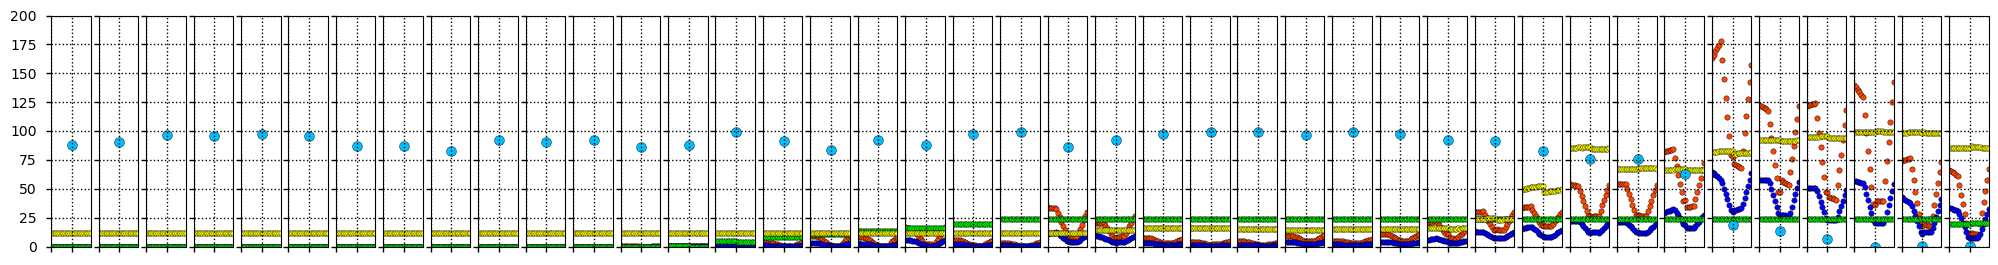

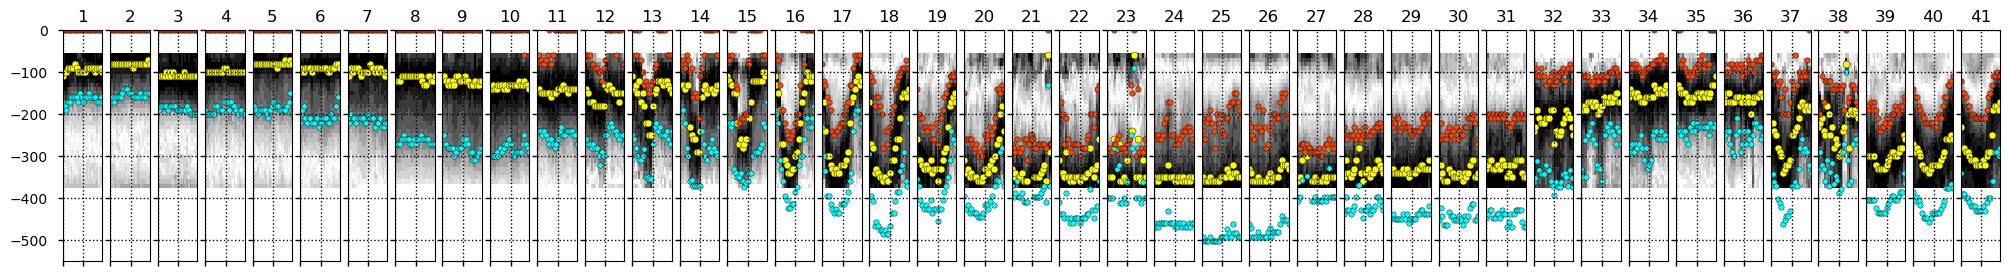

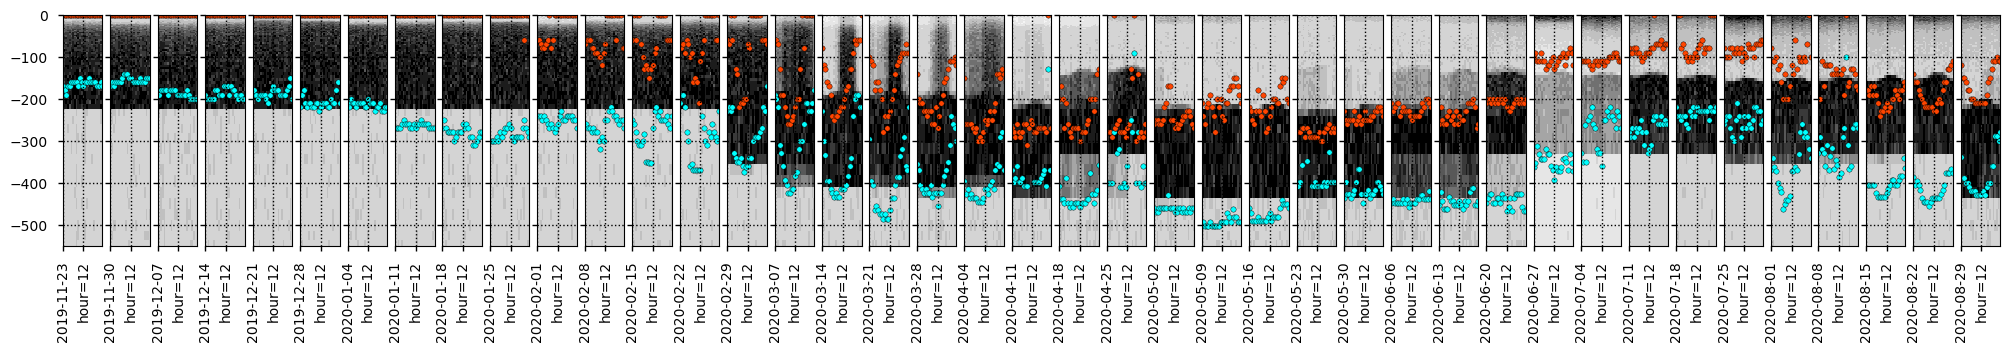

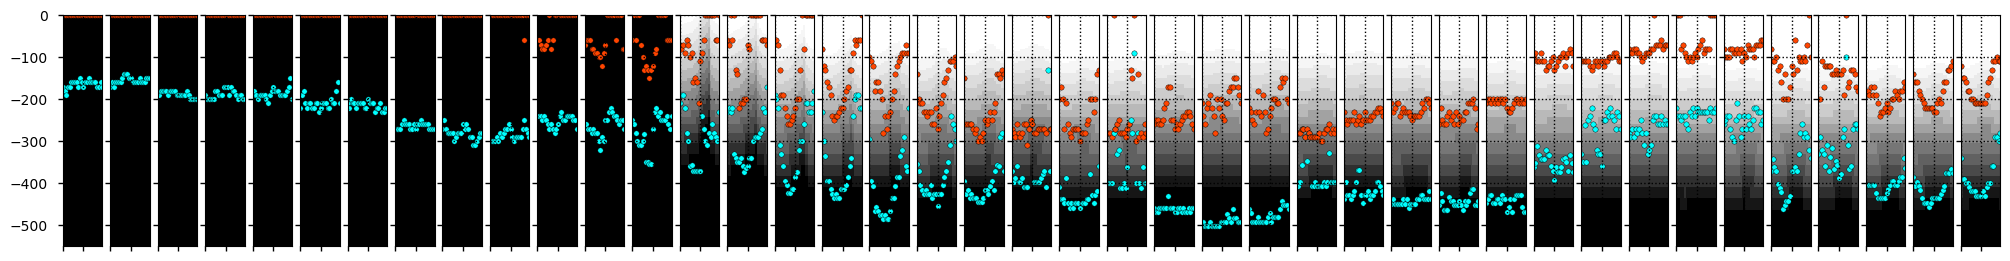

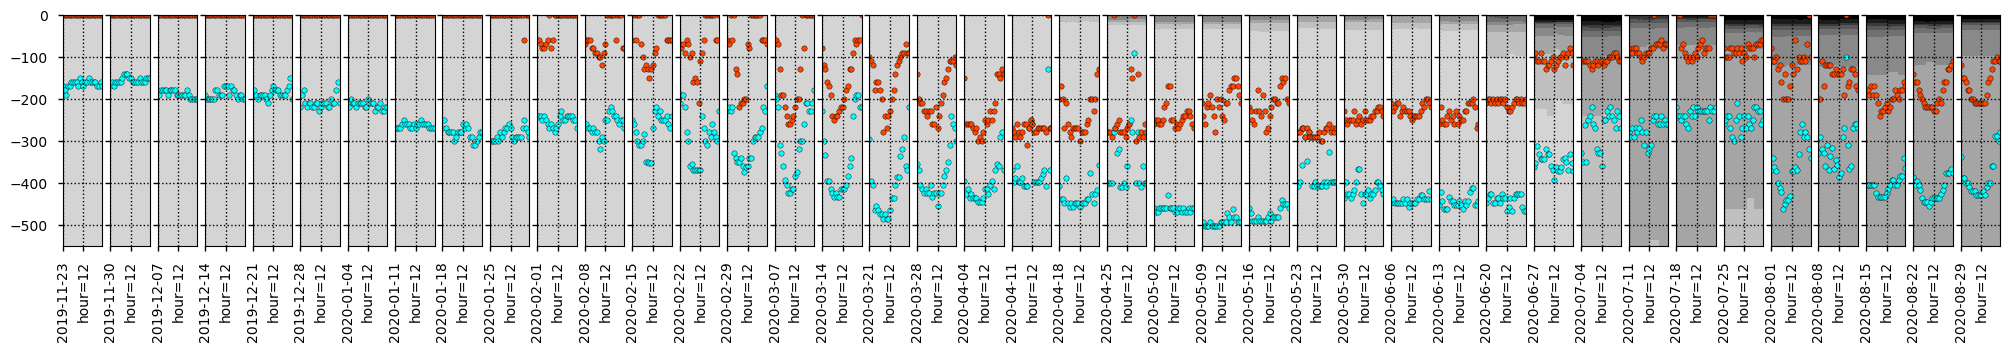

In [16]:
# CENTER OF MASS SELECTION ATWAIN 1
from scipy import ndimage
n=41
plots = np.arange(n) #[20,22,37] #np.arange(n) #[1,17,28]
exclude = [1,21,23,26,34,35,37,38]

newDepth = np.concatenate((ATW1_depth,np.array([50.0, 40.0, 30.0, 20.0,10.0,0.5])))
thickness = np.zeros((newDepth.shape))
for d in range(newDepth.shape[0]):
    if d == 0: 
        thickness[d] = 10.0
    elif d == newDepth.shape[0]-1:
        thickness[d] = 1.0
    else:
        thickness[d] = (newDepth[d-1] - newDepth[d])/2. + (newDepth[d] - newDepth[d+1])/2.

# aveHycMint = np.zeros((newDepth.shape[0],aveHycMATW1.shape[1]))
# aveHycMtotal = np.zeros((aveHycMATW1.shape[1]))
# for t in range(aveHycMATW1.shape[1]):
#     aveHycMint[:,t] = np.interp(newDepth,-ATWconstDEPTH,aveHycMATW1[:,t])
#     aveHycMtotal[t] = np.sum(aveHycMint[:,t]*thickness)
# maxfood = np.max(aveHycMtotal)

# aveHycLint = np.zeros((newDepth.shape[0],aveHycLATW1.shape[1]))
# for t in range(aveHycLATW1.shape[1]):
#     aveHycLint[:,t] = np.interp(newDepth,-ATWconstDEPTH,aveHycLATW1[:,t])

aveModLint = np.zeros((newDepth.shape[0],aveModLATW1.shape[1]))
aveModFint = np.zeros((newDepth.shape[0],aveModLATW1.shape[1]))
aveModFtotal = np.zeros((aveModFATW1.shape[1]))
aveModMint = np.zeros((newDepth.shape[0],aveModMATW1.shape[1]))
for t in range(aveModLATW1.shape[1]):
    aveModLint[:,t] = np.interp(-newDepth,md[0,:],aveModLATW1[:,t])
    aveModFint[:,t] = np.interp(-newDepth,md[0,:],aveModFATW1[:,t])
    aveModMint[:,t] = np.interp(-newDepth,md[0,:],aveModMATW1[:,t])
    aveModFtotal[t] = np.sum(aveModFint[:,t]*thickness)
maxfoodMod = np.max(aveModFtotal)


figsx = 25
dates = ATW1_datetime[0]
fig4, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

x1=-24
x2=0

counted=1
t = 0
for c in range(n):
    if c in plots:
        axs[t].set_ylim(0,200)
        axs[t].set_xlim(0,23)

        period = np.copy(avessrATW1[x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt],s=15,color='orangered',edgecolor='black')
            if c+1 not in exclude: # c != 1:
                dataset['era5'].append(period[tt]*0.42) #
                dataset['parmean0'].append( np.mean(period)*0.42 )
        period = np.copy(aveModLint[-1,x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt],s=15,color='blue',edgecolor='black')
            if c+1 not in exclude: # c != 1:    
                dataset['light_below_surface'].append(period[tt])
        period = np.copy(avedlATW1[x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt],s=15,color='lime',edgecolor='black')
            if c+1 not in exclude: # c != 1:
                dataset['hours'].append(period[tt])
        for tt in range(24):
            if c+1 not in exclude: # c != 1:        
                dataset['bathy'].append(800.0)

        # period = np.copy(aveHycMtotal[x1+24:x2+24])
        # for tt in range(24):
        #     pp1 = axs[t].scatter(tt,period[tt]/maxfood*100.,s=15,color='yellow',edgecolor='black')

        period = np.copy(aveModFtotal[x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt]/maxfoodMod*100.,s=15,color='yellow',edgecolor='black')
            if c+1 not in exclude: # c != 1:    
                dataset['food'].append(period[tt])

        period = np.copy(aveiceATW1[x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt],s=50,color='deepskyblue',edgecolor='black')

        for tt in range(24):
            if c+1 not in exclude: # c != 1:
                dataset['dates'].append( 'ATW' + str(dates) )

        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels(['', ''],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')

        t = t + 1    
        dates = dates + datetime.timedelta(days=averaging_days)
        x1 = x1 + 24
        x2 = x2 + 24

        counted = counted + 1
plt.subplots_adjust(wspace=0.2)

figsx = 25
dates = ATW1_datetime[0]

fig4, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

x1=-24
x2=0


normalized = np.zeros((aveATW1.shape)) - 9999.
for t in range(len(aveATW1[0,:])):
    column = aveATW1[:,t]
    column = np.ma.masked_invalid(column)
    column = column - np.min(column)
    normalized[:,t] = column/np.max(column)
normalized = np.ma.masked_where(normalized<0.0, normalized)

slevels=np.array([0.,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1.])
snorm = BoundaryNorm(slevels, ncolors=cmap.N, clip=True)

upper = np.zeros((n,24))-1E10
lower = np.zeros((n,24))-1E10
upperd = np.zeros((n,24))
lowerd = np.zeros((n,24))
counted=1
t = 0
yylim = -550
for c in range(n):
    if c in plots: 
        axs[t].set_ylim(yylim,0)
        axs[t].set_xlim(0,23)
        period = np.copy(normalized[:,x1+24:x2+24])

        period999 = np.copy(normalized[:,x1+24:x2+24])
        period999[period999<0.8] = 0.

        p = axs[t].pcolormesh(np.arange(24),-ATW1_depth,period,cmap=plt.get_cmap('Greys'),norm=snorm)

        count_existing=0
        distance = 0.0
        CentMassAll = np.zeros((24))
        for tt in range(24):
            CentMass = period999[:,tt]
            CentMass = np.ma.masked_invalid(CentMass)

            center_of_mass = int(np.round(ndimage.center_of_mass(CentMass.filled(0))))
            CentMassAll[tt] = center_of_mass
            pp1 = axs[t].scatter(tt,-ATW1_depth[center_of_mass],s=25,color='yellow',edgecolor='black')

            for d in range(center_of_mass,0,-1):
                #print(tt,d,-ATW1_depth[d])
                if np.abs(period[d,tt] - 0.4)<0.125:
#                    lowerd[c,tt] = d
                    lower[c,tt] = -ATW1_depth[d] #period[d,tt]
#                    pp2 = axs[t].scatter(tt,-ATW1_depth[d],s=25,color='cyan',edgecolor='black')
                    distance = distance + np.abs( np.abs(ATW1_depth[d]) - np.abs(ATW1_depth[center_of_mass]) )
                    count_existing = count_existing + 1
                    break
            for d in range(center_of_mass,ATW1_depth.shape[0]):
                if np.abs(period[d,tt] - 0.4)<0.125:
#                    upperd[c,tt] = d
                    upper[c,tt] = -ATW1_depth[d] #period[d,tt]
#                    pp3 = axs[t].scatter(tt,-ATW1_depth[d],s=25,color='orangered',edgecolor='black')
                    count_existing = count_existing + 1
                    distance = distance + np.abs( np.abs(ATW1_depth[d]) - np.abs(ATW1_depth[center_of_mass]) )
                    break
        distance = distance / count_existing
        for tt in range(24):
            if upper[c,tt] < -1E9:
               upper[c,tt] = np.max([np.min([-ATW1_depth[int(CentMassAll[tt])] + distance, -0.5]),-0.5])
            if lower[c,tt] < -1E9:
               lower[c,tt] = -ATW1_depth[int(CentMassAll[tt])] - distance
            pp2 = axs[t].scatter(tt,lower[c,tt],s=15,color='cyan',edgecolor='black')
            pp3 = axs[t].scatter(tt,upper[c,tt],s=15,color='orangered',edgecolor='black')         

        p.set_clim(0,1)        
        axs[t].set_title(str(counted))
    
        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels(['', ''],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')

        t = t + 1    
    dates = dates + datetime.timedelta(days=averaging_days)
    x1 = x1 + 24
    x2 = x2 + 24

    counted = counted + 1

plt.subplots_adjust(wspace=0.2)

dates = ATW1_datetime[0]
biolevels=np.array([0.,1.,5.,10.,25.,50.,100.,200.,300., 400., 500., 750., 1000.])
bionorm = BoundaryNorm(biolevels, ncolors=cmap.N, clip=True)
from matplotlib.ticker import FuncFormatter

# normalize the migrator concentration similar to backscatter above for consistency
normalized = np.zeros((aveModMATW1.shape)) - 9999.
for t in range(len(aveModMATW1[0,:])):
    column = aveModMATW1[:,t]
    column = np.ma.masked_invalid(column)
    column = column - np.min(column)
    normalized[:,t] = column/np.max(column)
naveModMATW1 = np.ma.masked_where(normalized<0.0, normalized)


fig6, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

x1=-24
x2=0

t = 0
for c in range(n):
    if c in plots:
        axs[t].set_ylim(yylim,0)
        axs[t].set_xlim(0,23)
        p = axs[t].pcolormesh(np.arange(24),md[0,:],naveModMATW1[:,x1+24:x2+24],cmap=plt.get_cmap('Greys'),norm=snorm)
        # if c+1 in exclude:
        #     pex1 = axs[t].plot([0,24],[yylim,0.0], color='red',linewidth=3)
        #     pex2 = axs[t].plot([0,24],[0.0,yylim], color='red',linewidth=3) 

        for tt in range(24):
            pp1 = axs[t].scatter(tt,lower[c,tt],s=15,color='cyan',edgecolor='black')
            pp2 = axs[t].scatter(tt,upper[c,tt],s=15,color='orangered',edgecolor='black')

        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels([dates.strftime('%Y-%m-%d'), 'hour=12'],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')

        t = t + 1    
    dates = dates + datetime.timedelta(days=averaging_days)
    x1 = x1 + 24
    x2 = x2 + 24

plt.subplots_adjust(wspace=0.2)


dates = ATW1_datetime[0]
fig2, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

levels=np.array([0.,1E-15,1E-14,1E-13,1E-12,1E-11,1E-10,1E-9,1E-8,1E-7,1E-6,1E-5,1E-4,1E-3,1])
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
from matplotlib.ticker import FuncFormatter

x1=-24
x2=0

t = 0
for c in range(n):
    if c in plots:

        axs[t].set_ylim(yylim,0)
        axs[t].set_xlim(0,23)
        period = np.copy(aveModLint[:,x1+24:x2+24])
        p = axs[t].pcolormesh(np.arange(24),md[0,:],aveModLATW1[:,x1+24:x2+24], norm=norm,cmap=plt.get_cmap('Greys_r'))
        parmean = np.zeros((aveModLATW1[:,x1+24:x2+24].shape[0]))
        for dpar in range( aveModLATW1[:,x1+24:x2+24].shape[0] ):
            parmean[dpar] = np.mean(aveModLATW1[dpar,x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,lower[c,tt],s=15,color='cyan',edgecolor='black')
            pp2 = axs[t].scatter(tt,upper[c,tt],s=15,color='orangered',edgecolor='black')
            if c+1 not in exclude: # c != 1:
                upperlight = np.interp(upper[c,tt],md[0,:],aveModLATW1[:,x1+24+tt])
                upperparmean = np.interp(upper[c,tt],md[0,:],parmean)
                lowerlight = np.interp(lower[c,tt],md[0,:],aveModLATW1[:,x1+24+tt])
                lowerparmean = np.interp(lower[c,tt],md[0,:],parmean)
                dataset['upperlight'].append( upperlight )
                dataset['upperdepth'].append( upper[c,tt] )
                dataset['lowerlight'].append( lowerlight )
                dataset['lowerdepth'].append( lower[c,tt] )
                dataset['upperparmean'].append( upperparmean )
                dataset['lowerparmean'].append( lowerparmean )
        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels(['', ''],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')
    
        t = t + 1
    dates = dates + datetime.timedelta(days=averaging_days)
    x1 = x1 + 24
    x2 = x2 + 24

plt.subplots_adjust(wspace=0.2)

dates = ATW1_datetime[0]
biolevels=np.array([0.,0.1,0.5,1.,2.5,5.0,10.,20.,30., 40., 50., 75., 100.])
bionorm = BoundaryNorm(biolevels, ncolors=cmap.N, clip=True)
from matplotlib.ticker import FuncFormatter

fig3, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

x1=-24
x2=0

t = 0
for c in range(n):
    if c in plots:
        axs[t].set_ylim(yylim,0)
        axs[t].set_xlim(0,23)
        p = axs[t].pcolormesh(np.arange(24),md[0,:],aveModFATW1[:,x1+24:x2+24],cmap=plt.get_cmap('Greys'),norm=bionorm)

        for tt in range(24):
            pp1 = axs[t].scatter(tt,lower[c,tt],s=15,color='cyan',edgecolor='black')
            pp2 = axs[t].scatter(tt,upper[c,tt],s=15,color='orangered',edgecolor='black')

            if c+1 not in exclude: # c != 1:
                upperfood = np.interp(upper[c,tt],md[0,:],aveModFATW1[:,x1+24+tt])
                lowerfood = np.interp(lower[c,tt],md[0,:],aveModFATW1[:,x1+24+tt])
                dataset['upperfood'].append( upperfood )
                dataset['lowerfood'].append( lowerfood )
        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels([dates.strftime('%Y-%m-%d'), 'hour=12'],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')

        t = t + 1    
    dates = dates + datetime.timedelta(days=averaging_days)
    x1 = x1 + 24
    x2 = x2 + 24

plt.subplots_adjust(wspace=0.2)

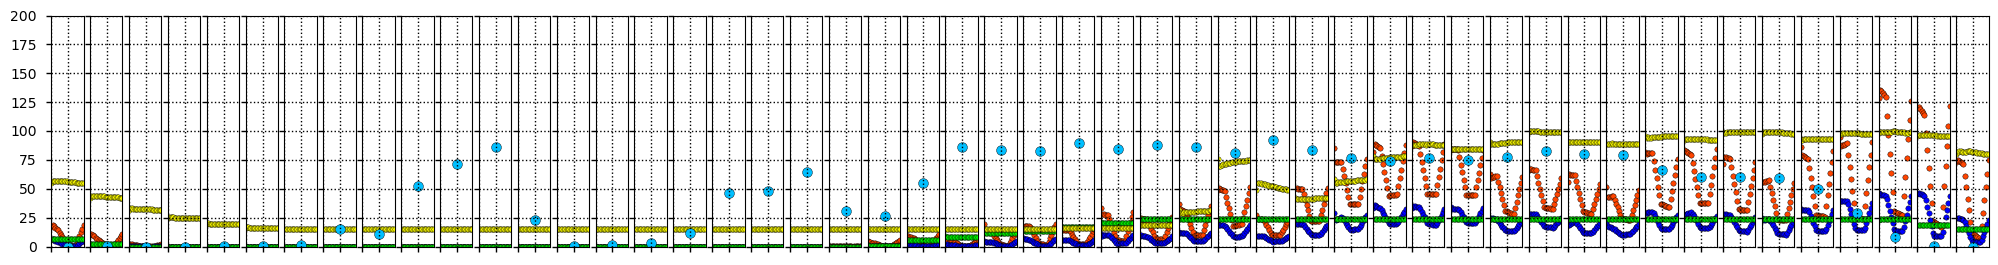

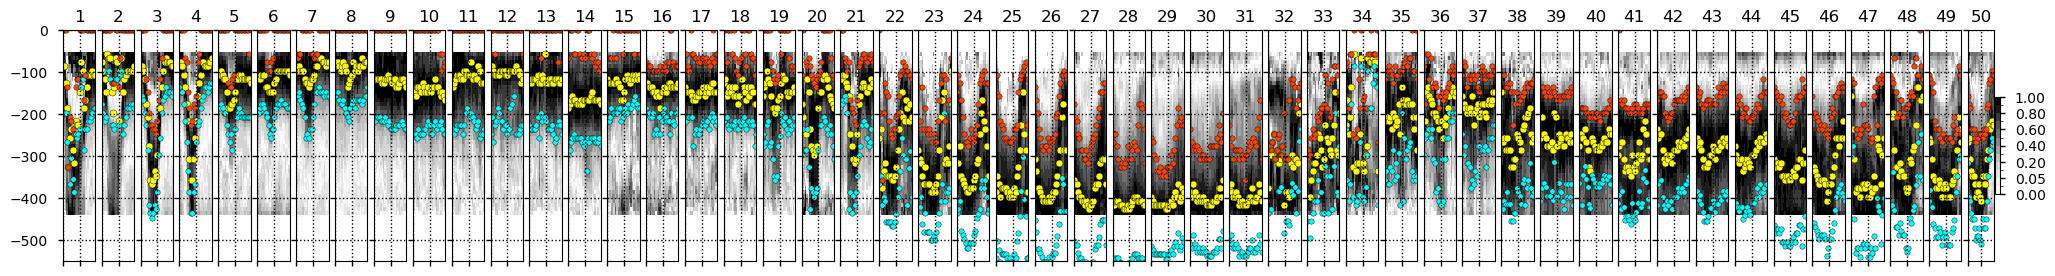

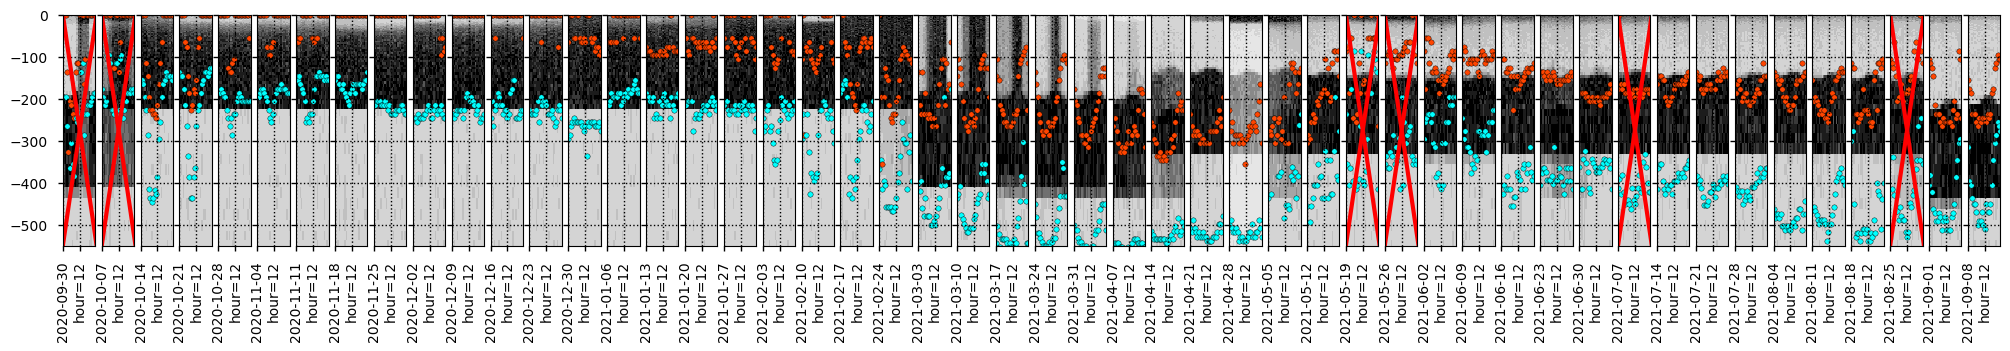

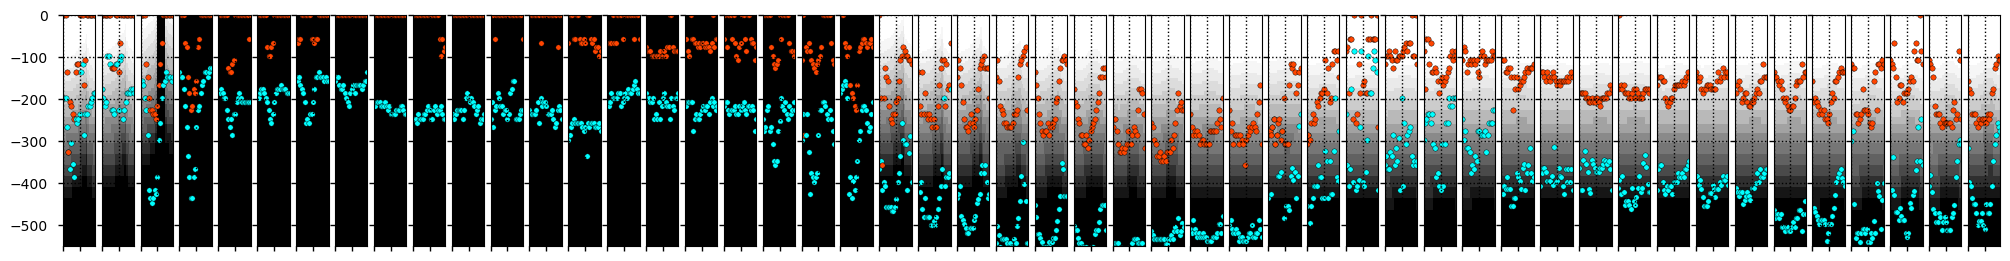

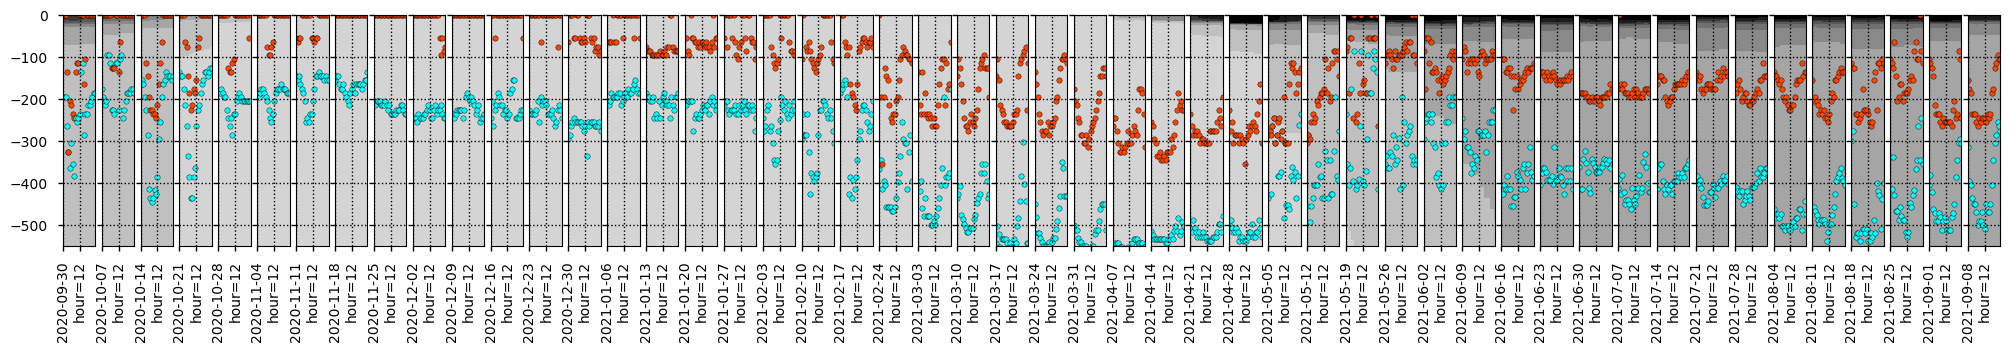

In [17]:
# CENTER OF MASS SELECTION ATWAIN 2
from scipy import ndimage
n=50
plots = np.arange(n) #[20,22,37] #np.arange(n) #[1,17,28]
exclude = [1,2,34,35,41,48]

newDepth = np.concatenate((ATW2_depth,np.array([50.0, 40.0, 30.0, 20.0,10.0,0.5])))
thickness = np.zeros((newDepth.shape))
for d in range(newDepth.shape[0]):
    if d == 0: 
        thickness[d] = 10.0
    elif d == newDepth.shape[0]-1:
        thickness[d] = 1.0
    else:
        thickness[d] = (newDepth[d-1] - newDepth[d])/2. + (newDepth[d] - newDepth[d+1])/2.

# aveHycMint = np.zeros((newDepth.shape[0],aveHycMATW2.shape[1]))
# aveHycMtotal = np.zeros((aveHycMATW2.shape[1]))
# for t in range(aveHycMATW2.shape[1]):
#     aveHycMint[:,t] = np.interp(newDepth,-ATWconstDEPTH,aveHycMATW2[:,t])
#     aveHycMtotal[t] = np.sum(aveHycMint[:,t]*thickness)
# maxfood = np.max(aveHycMtotal)

# aveHycLint = np.zeros((newDepth.shape[0],aveHycLATW2.shape[1]))
# for t in range(aveHycLATW2.shape[1]):
#     aveHycLint[:,t] = np.interp(newDepth,-ATWconstDEPTH,aveHycLATW2[:,t])

aveModLint = np.zeros((newDepth.shape[0],aveModLATW2.shape[1]))
aveModFint = np.zeros((newDepth.shape[0],aveModLATW2.shape[1]))
aveModFtotal = np.zeros((aveModFATW2.shape[1]))
aveModMint = np.zeros((newDepth.shape[0],aveModMATW2.shape[1]))

for t in range(aveModLATW2.shape[1]):
    aveModLint[:,t] = np.interp(-newDepth,md[0,:],aveModLATW2[:,t])
    aveModFint[:,t] = np.interp(-newDepth,md[0,:],aveModFATW2[:,t])
    aveModMint[:,t] = np.interp(-newDepth,md[0,:],aveModMATW2[:,t])
    aveModFtotal[t] = np.sum(aveModFint[:,t]*thickness)
maxfoodMod = np.max(aveModFtotal)


figsx = 25
dates = ATW2_datetime[0]
fig4, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

x1=-24
x2=0

counted=1
t = 0
for c in range(n):
    if c in plots:
        axs[t].set_ylim(0,200)
        axs[t].set_xlim(0,23)

        period = np.copy(avessrATW2[x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt],s=15,color='orangered',edgecolor='black')
            if c+1 not in exclude:
                dataset['era5'].append(period[tt]*0.42)
                dataset['parmean0'].append( np.mean(period)*0.42 )
        period = np.copy(aveModLint[-1,x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt],s=15,color='blue',edgecolor='black')
            if c+1 not in exclude:    
                dataset['light_below_surface'].append(period[tt])
        period = np.copy(avedlATW2[x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt],s=15,color='lime',edgecolor='black')
            if c+1 not in exclude:
                dataset['hours'].append(period[tt])
        for tt in range(24):
            if c+1 not in exclude:        
                dataset['bathy'].append(800.0)

        # period = np.copy(aveHycMtotal[x1+24:x2+24])
        # for tt in range(24):
        #     pp1 = axs[t].scatter(tt,period[tt]/maxfood*100.,s=15,color='yellow',edgecolor='black')

        period = np.copy(aveModFtotal[x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt]/maxfoodMod*100.,s=15,color='yellow',edgecolor='black')
            if c+1 not in exclude:    
                dataset['food'].append(period[tt])

        period = np.copy(aveiceATW2[x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,period[tt],s=50,color='deepskyblue',edgecolor='black')

        for tt in range(24):
            if c+1 not in exclude: # c != 1:
                dataset['dates'].append( 'ATW' + str(dates) )

        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels(['', ''],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')

        t = t + 1    
        dates = dates + datetime.timedelta(days=averaging_days)
        x1 = x1 + 24
        x2 = x2 + 24

        counted = counted + 1
plt.subplots_adjust(wspace=0.2)

figsx = 25
dates = ATW2_datetime[0]

fig4, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

x1=-24
x2=0


normalized = np.zeros((aveATW2.shape)) - 9999.
for t in range(len(aveATW2[0,:])):
    column = aveATW2[:,t]
    column = np.ma.masked_invalid(column)
    column = column - np.min(column)
    normalized[:,t] = column/np.max(column)
normalized = np.ma.masked_where(normalized<0.0, normalized)

slevels=np.array([0.,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1.])
snorm = BoundaryNorm(slevels, ncolors=cmap.N, clip=True)

upper = np.zeros((n,24))-1E10
lower = np.zeros((n,24))-1E10
upperd = np.zeros((n,24))
lowerd = np.zeros((n,24))
counted=1
t = 0
yylim = -550
for c in range(n):
    if c in plots: 
        axs[t].set_ylim(yylim,0)
        axs[t].set_xlim(0,23)
        period = np.copy(normalized[:,x1+24:x2+24])

        period999 = np.copy(normalized[:,x1+24:x2+24])
        period999[period999<0.8] = 0.

        p = axs[t].pcolormesh(np.arange(24),-ATW2_depth,period,cmap=plt.get_cmap('Greys'), norm=snorm)
        if c == n-1 : plt.colorbar(p)

        count_existing=0
        distance = 0.0
        CentMassAll = np.zeros((24))
        for tt in range(24):
            CentMass = period999[:,tt]
            CentMass = np.ma.masked_invalid(CentMass)

            center_of_mass = int(np.round(ndimage.center_of_mass(CentMass.filled(0))))
            CentMassAll[tt] = center_of_mass
            pp1 = axs[t].scatter(tt,-ATW2_depth[center_of_mass],s=25,color='yellow',edgecolor='black')

            for d in range(center_of_mass,0,-1):
                #print(tt,d,-ATW2_depth[d])
                if np.abs(period[d,tt] - 0.4)<0.125:
#                    lowerd[c,tt] = d
                    lower[c,tt] = -ATW2_depth[d] #period[d,tt]
#                    pp2 = axs[t].scatter(tt,-ATW2_depth[d],s=25,color='cyan',edgecolor='black')
                    distance = distance + np.abs( np.abs(ATW2_depth[d]) - np.abs(ATW2_depth[center_of_mass]) )
                    count_existing = count_existing + 1
                    break
            for d in range(center_of_mass,ATW2_depth.shape[0]):
                if np.abs(period[d,tt] - 0.4)<0.125:
#                    upperd[c,tt] = d
                    upper[c,tt] = -ATW2_depth[d] #period[d,tt]
#                    pp3 = axs[t].scatter(tt,-ATW2_depth[d],s=25,color='orangered',edgecolor='black')
                    count_existing = count_existing + 1
                    distance = distance + np.abs( np.abs(ATW2_depth[d]) - np.abs(ATW2_depth[center_of_mass]) )
                    break
        distance = distance / count_existing
        for tt in range(24):
            if upper[c,tt] < -1E9:
               upper[c,tt] = np.max([np.min([-ATW2_depth[int(CentMassAll[tt])] + distance, -0.5]),-0.5])
            if lower[c,tt] < -1E9:
               lower[c,tt] = -ATW2_depth[int(CentMassAll[tt])] - distance
            pp2 = axs[t].scatter(tt,lower[c,tt],s=15,color='cyan',edgecolor='black')
            pp3 = axs[t].scatter(tt,upper[c,tt],s=15,color='orangered',edgecolor='black')         

        p.set_clim(0,1)        
        axs[t].set_title(str(counted))
    
        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels(['', ''],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')

        t = t + 1    
    dates = dates + datetime.timedelta(days=averaging_days)
    x1 = x1 + 24
    x2 = x2 + 24

    counted = counted + 1

plt.subplots_adjust(wspace=0.2)


dates = ATW2_datetime[0]
biolevels=np.array([0.,1.,5.,10.,25.,50.,100.,200.,300., 400., 500., 750., 1000.])
bionorm = BoundaryNorm(biolevels, ncolors=cmap.N, clip=True)
from matplotlib.ticker import FuncFormatter

# normalize the migrator concentration similar to backscatter above for consistency
normalized = np.zeros((aveModMATW2.shape)) - 9999.
for t in range(len(aveModMATW2[0,:])):
    column = aveModMATW2[:,t]
    column = np.ma.masked_invalid(column)
    column = column - np.min(column)
    normalized[:,t] = column/np.max(column)
naveModMATW2 = np.ma.masked_where(normalized<0.0, normalized)


fig6, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

x1=-24
x2=0

t = 0
for c in range(n):
    if c in plots:
        axs[t].set_ylim(yylim,0)
        axs[t].set_xlim(0,23)
        p = axs[t].pcolormesh(np.arange(24),md[0,:],naveModMATW2[:,x1+24:x2+24],cmap=plt.get_cmap('Greys'),norm=snorm)
        if c+1 in exclude:
            pex1 = axs[t].plot([0,24],[yylim,0.0], color='red',linewidth=3)
            pex2 = axs[t].plot([0,24],[0.0,yylim], color='red',linewidth=3)

        for tt in range(24):
            pp1 = axs[t].scatter(tt,lower[c,tt],s=15,color='cyan',edgecolor='black')
            pp2 = axs[t].scatter(tt,upper[c,tt],s=15,color='orangered',edgecolor='black')

        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels([dates.strftime('%Y-%m-%d'), 'hour=12'],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')

        t = t + 1    
    dates = dates + datetime.timedelta(days=averaging_days)
    x1 = x1 + 24
    x2 = x2 + 24

plt.subplots_adjust(wspace=0.2)

dates = ATW2_datetime[0]
fig2, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

levels=np.array([0.,1E-15,1E-14,1E-13,1E-12,1E-11,1E-10,1E-9,1E-8,1E-7,1E-6,1E-5,1E-4,1E-3,1])
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
from matplotlib.ticker import FuncFormatter

x1=-24
x2=0

t = 0
for c in range(n):
    if c in plots:

        axs[t].set_ylim(yylim,0)
        axs[t].set_xlim(0,23)
        period = np.copy(aveModLint[:,x1+24:x2+24])
        p = axs[t].pcolormesh(np.arange(24),md[0,:],aveModLATW2[:,x1+24:x2+24], norm=norm,cmap=plt.get_cmap('Greys_r'))
        parmean = np.zeros((aveModLATW2[:,x1+24:x2+24].shape[0]))
        for dpar in range( aveModLATW2[:,x1+24:x2+24].shape[0] ):
            parmean[dpar] = np.mean(aveModLATW2[dpar,x1+24:x2+24])
        for tt in range(24):
            pp1 = axs[t].scatter(tt,lower[c,tt],s=15,color='cyan',edgecolor='black')
            pp2 = axs[t].scatter(tt,upper[c,tt],s=15,color='orangered',edgecolor='black')
            if c+1 not in exclude:
                upperlight = np.interp(upper[c,tt],md[0,:],aveModLATW2[:,x1+24+tt])
                upperparmean = np.interp(upper[c,tt],md[0,:],parmean)
                lowerlight = np.interp(lower[c,tt],md[0,:],aveModLATW2[:,x1+24+tt])
                lowerparmean = np.interp(lower[c,tt],md[0,:],parmean)
                dataset['upperlight'].append( upperlight )
                dataset['upperdepth'].append( upper[c,tt] )
                dataset['lowerlight'].append( lowerlight )
                dataset['lowerdepth'].append( lower[c,tt] )
                dataset['upperparmean'].append( upperparmean )
                dataset['lowerparmean'].append( lowerparmean )
        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels(['', ''],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')
    
        t = t + 1
    dates = dates + datetime.timedelta(days=averaging_days)
    x1 = x1 + 24
    x2 = x2 + 24

plt.subplots_adjust(wspace=0.2)

dates = ATW2_datetime[0]
biolevels=np.array([0.,0.1,0.5,1.,2.5,5.0,10.,20.,30., 40., 50., 75., 100.])
bionorm = BoundaryNorm(biolevels, ncolors=cmap.N, clip=True)
from matplotlib.ticker import FuncFormatter

fig3, axs  = plt.subplots(1,len(plots),figsize=(figsx,3),sharey=True,facecolor="w")

x1=-24
x2=0

t = 0
for c in range(n):
    if c in plots:
        axs[t].set_ylim(yylim,0)
        axs[t].set_xlim(0,23)
        p = axs[t].pcolormesh(np.arange(24),md[0,:],aveModFATW2[:,x1+24:x2+24],cmap=plt.get_cmap('Greys'),norm=bionorm)

        for tt in range(24):
            pp1 = axs[t].scatter(tt,lower[c,tt],s=15,color='cyan',edgecolor='black')
            pp2 = axs[t].scatter(tt,upper[c,tt],s=15,color='orangered',edgecolor='black')

            if c+1 not in exclude:
                upperfood = np.interp(upper[c,tt],md[0,:],aveModFATW2[:,x1+24+tt])
                lowerfood = np.interp(lower[c,tt],md[0,:],aveModFATW2[:,x1+24+tt])
                dataset['upperfood'].append( upperfood )
                dataset['lowerfood'].append( lowerfood )
        axs[t].set_xticks([0, 12])
        axs[t].set_xticklabels([dates.strftime('%Y-%m-%d'), 'hour=12'],rotation=90)
        axs[t].grid(True, linestyle=':', color='black')

        t = t + 1    
    dates = dates + datetime.timedelta(days=averaging_days)
    x1 = x1 + 24
    x2 = x2 + 24

plt.subplots_adjust(wspace=0.2)

In [18]:
import pickle
#file = open('MLdataset1D_FRAM_fixed_parmean_ECOSMOv2025_cap99_hycom_corrected_6hour.pckl','wb')
#file = open('test.pckl','wb')
file = open('inputs.pckl','wb')
pickle.dump(dataset,file)
file.close()

import pickle
#file = open('MLdataset1D_FRAM_fixed_parmean_ECOSMOv2025_cap99_hycom_corrected_6hour.pckl','rb')
#file = open('test.pckl','rb')
file = open('inputs.pckl','rb')
dataset = pickle.load(file)
print(dataset.keys())

for names in dataset.keys():
    print(names,len(dataset[names]))

dict_keys(['era5', 'hours', 'light_below_surface', 'upperdepth', 'lowerdepth', 'upperlight', 'lowerlight', 'bathy', 'food', 'upperfood', 'lowerfood', 'dates', 'upperparmean', 'lowerparmean', 'parmean0'])
era5 1848
hours 1848
light_below_surface 1848
upperdepth 1848
lowerdepth 1848
upperlight 1848
lowerlight 1848
bathy 1848
food 1848
upperfood 1848
lowerfood 1848
dates 1848
upperparmean 1848
lowerparmean 1848
parmean0 1848


## Machine Learning Algorithms
### Codes below will load the dataset produced above.

In [19]:
import pickle
import matplotlib.pyplot as plt

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from math import sqrt

import pandas as pd
import datetime
import matplotlib.dates as mdates

In [16]:
#file = open('MLdataset1D_FRAM_fixed_parmean_ECOSMOv2025_cap99_hycom_corrected_6hour.pckl','rb')
#file = open('ML.check1.pckl','rb')
file = open('inputs.pckl','rb')
#file = open('MLdataset1D.pckl','rb')
dataset = pickle.load(file)
print(dataset.keys())
feat_1d = {'era5','hours','light_below_surface','upperdepth', 'lowerdepth', 'upperlight', 'lowerlight', 'bathy', 'food','upperfood','lowerfood','parmean0','upperparmean','lowerparmean'}

plotdates = []
for t in range( len(dataset['dates']) ):
 if dataset['dates'][t][0:3] == 'ATW':
    plotdates.append( datetime.datetime(int(dataset['dates'][t][3:7]), int(dataset['dates'][t][8:10]), int(dataset['dates'][t][11:13])) )
pddates = pd.to_datetime(plotdates)

dict_keys(['era5', 'hours', 'light_below_surface', 'upperdepth', 'lowerdepth', 'upperlight', 'lowerlight', 'bathy', 'food', 'upperfood', 'lowerfood', 'dates', 'upperparmean', 'lowerparmean', 'parmean0'])


### Some items in the dataset are post-processed to prevent bad values etc. Importantly, integrated mesozooplankton food cocentration (FOOD) is first normalised to a typical half saturation constant in order to remove the biogeochemical model unit differences. As such, ML algorithms will use a ratio of the FOOD available to a typical value that corresponds to a steep grazing rate curve. Further, the ratio is capped at 50 in order to make the FOOD input a region and model generic.   

In [20]:
FOOD = np.array(dataset['food'])
FOOD = FOOD / 40.0 # (mgc/m3) likely half-saturation constant 
FOOD[FOOD >= 50.0] = 50.0


column = np.array(dataset['upperlight']).squeeze();  # this is already PAR
column[column<1E-20] = 1E-20
UPPERLIGHT = np.log10( column )
column = np.array(dataset['lowerlight']).squeeze();  # this is already PAR
column[column<1E-20] = 1E-20
LOWERLIGHT = np.log10( column )

column = np.array(dataset['lowerparmean'])  # this is already PAR
column = np.nan_to_num(column,nan=1E-20)
column[column==0.0] = 1E-20
LOWERPARMEAN = np.log10(column)

column = np.array(dataset['upperparmean']) # this is already PAR 
column = np.nan_to_num(column,nan=1E-20)
column[column==0.0] = 1E-20
UPPERPARMEAN = np.log10(column)

LOWERDEPTH = np.array(dataset['lowerdepth'])

column = np.array(dataset['parmean0']) # still ERA5 mean as full swr
column = column * 0.42 # convert to PAR since FABM code reads PAR
column[column<1E-20] = 1E-20
column = np.log10( column )
print('parmean',column.min(),column.max())
#column[column > 1.0] = 1.0
PARMEAN0 = column / 1.0

column = np.array(dataset['era5']) # full swr
column = column * 1.0 # convert to PAR since FABM code reads PAR
column[column<1E-20] = 1E-20
column = np.log10( column )
print('era5',column.min(),column.max())
ERA5 = column 

HOURS = np.array(dataset['hours'])

yupper = np.array(UPPERLIGHT)
ylower = np.array(LOWERLIGHT)
yparmean = np.array(LOWERPARMEAN)
ydepth = np.array(LOWERDEPTH)


nupper = yupper.shape[0]
nlower = ylower.shape[0]
nparmean = yparmean.shape[0]
ndepth = ydepth.shape[0]

X = np.zeros((nupper,4)) 
X[:,0] = FOOD.squeeze()
X[:,1] = ERA5.squeeze()
X[:,2] = HOURS.squeeze()
X[:,3] = PARMEAN0.squeeze()
#X[:,4] = UPPERPARMEAN.squeeze()
#X[:,5] = UPPERFOOD.squeeze()

#feature_names = ['food', 'era5','hours','parmean0','upperparmean','upperfood']
feature_names = ['food', 'era5','hours','parmean0']
target_upper = 'upper_light'
target_lower = 'lower_light'
target_parmean = 'lower_parmean'
target_lower_depth = 'lower_depth'


parmean -20.0 1.3270854392715477
era5 -20.0 1.873375306532192


## The ML algorithms separate the dataset to 4 cases: 1. POLAR night, 2. POLAR summer, 3. Daytime, 4. Nighttime

## The algorithms will produce a decision tree output. These are then need to be coded as if/else cases in the respective biogeochemical model codes.

### Below is polar night (number of daylight hours <0.1)

|--- parmean0 <= -10.83
|   |--- value: [-221.44]
|--- parmean0 >  -10.83
|   |--- value: [-298.68]

DEPTH
food 0.0
era5 0.0
hours 0.0
parmean0 1.0


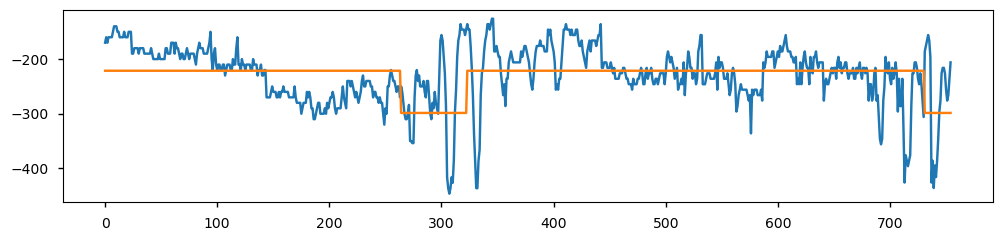

In [21]:
index = HOURS.squeeze() < 0.1
WINTER_ydepth = np.array(LOWERDEPTH)[index]

WINTER_ndepth = WINTER_ydepth.shape[0]

Xwinter = np.zeros((WINTER_ndepth,4)) 
Xwinter[:,0] = FOOD.squeeze()[index]
Xwinter[:,1] = ERA5.squeeze()[index]
Xwinter[:,2] = HOURS.squeeze()[index]
Xwinter[:,3] = PARMEAN0.squeeze()[index]

indexes = np.concatenate([np.arange(i, min(i+24, len(Xwinter[:,0]))) for i in range(0, len(Xwinter[:,0]), 48)])

WINTER_XDepthtrain = Xwinter[indexes,:]
WINTER_yDepthTrain = WINTER_ydepth[indexes]

mask = ~np.isnan(WINTER_XDepthtrain).any(axis=1) & ~np.isnan(WINTER_yDepthTrain)
WINTER_XDepthtrain = WINTER_XDepthtrain[mask]
WINTER_yDepthTrain = WINTER_yDepthTrain[mask]

n = 1
modelDepthDecisionTree = DecisionTreeRegressor(max_depth=n)
modelDepthDecisionTree.fit(WINTER_XDepthtrain, WINTER_yDepthTrain)

from sklearn.tree import export_text
import pandas as pd
Xwinter_df = pd.DataFrame(Xwinter, columns=feature_names)
tree_rules = export_text(modelDepthDecisionTree, feature_names=list(Xwinter_df.columns),max_depth=n)
print(tree_rules)

print('DEPTH')
for name,coef in zip(feature_names,modelDepthDecisionTree.feature_importances_):
    print(name,coef)

yDepthPredictDecisionTree = np.nan*np.ones_like(WINTER_ydepth)

maskall = ~np.isnan(Xwinter).any(axis=1) & ~np.isnan(WINTER_ydepth)
yDepthPredictDecisionTree[maskall] = modelDepthDecisionTree.predict(Xwinter[maskall])

fig, ax = plt.subplots(1,figsize=(12,2.5))
ax.plot(WINTER_ydepth)
ax.plot(yDepthPredictDecisionTree)

### Below is polar day (number of hours > 23.9).

Lowerlight Rules
|--- parmean0 <= 1.05
|   |--- value: [-14.62]
|--- parmean0 >  1.05
|   |--- value: [-8.13]

Upperlight Rules
|--- parmean0 <= 0.61
|   |--- value: [-8.06]
|--- parmean0 >  0.61
|   |--- value: [-4.16]

LOWERLIGHT
food 0.0
era5 0.0
hours 0.0
parmean0 1.0
UPPERLIGHT
food 0.0
era5 0.0
hours 0.0
parmean0 1.0


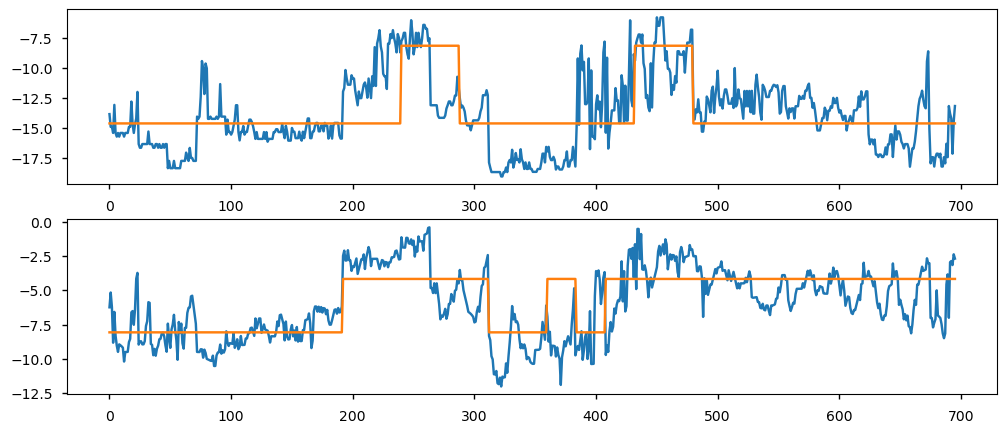

In [22]:
# THIS USES THE EXACT UPPER AND LOWER PARMEAN PREDICTIONS
# It also uses decision depth = 4 for lower light, and depth = 3 for upper light

index = HOURS.squeeze() > 23.9
SUMMER_ylowerlight = np.array(LOWERPARMEAN)[index]
SUMMER_yupperlight = np.array(UPPERLIGHT)[index]

SUMMER_nlowerlight = SUMMER_ylowerlight.shape[0]

Xsummer = np.zeros((SUMMER_nlowerlight,4)) 
Xsummer[:,0] = FOOD.squeeze()[index]
Xsummer[:,1] = ERA5.squeeze()[index]
Xsummer[:,2] = HOURS.squeeze()[index]
Xsummer[:,3] = PARMEAN0.squeeze()[index]

indexes = np.concatenate([np.arange(i, min(i+24, len(Xsummer[:,0]))) for i in range(0, len(Xsummer[:,0]), 48)])

SUMMER_XLowerlightTrain = Xsummer[indexes,:]
SUMMER_yLowerlightTrain = SUMMER_ylowerlight[indexes]
SUMMER_XUpperlightTrain = Xsummer[indexes,:]
SUMMER_yUpperlightTrain = SUMMER_yupperlight[indexes]

mask = ~np.isnan(SUMMER_XLowerlightTrain).any(axis=1) & ~np.isnan(SUMMER_yLowerlightTrain)
SUMMER_XLowerlightTrain = SUMMER_XLowerlightTrain[mask]
SUMMER_yLowerlightTrain = SUMMER_yLowerlightTrain[mask]
mask = ~np.isnan(SUMMER_XUpperlightTrain).any(axis=1) & ~np.isnan(SUMMER_yUpperlightTrain)
SUMMER_XUpperlightTrain = SUMMER_XUpperlightTrain[mask]
SUMMER_yUpperlightTrain = SUMMER_yUpperlightTrain[mask]

n = 1
modelLowerlightDecisionTree = DecisionTreeRegressor(max_depth=n)
modelLowerlightDecisionTree.fit(SUMMER_XLowerlightTrain, SUMMER_yLowerlightTrain)
n = 1
modelUpperlightDecisionTree = DecisionTreeRegressor(max_depth=n)
modelUpperlightDecisionTree.fit(SUMMER_XUpperlightTrain, SUMMER_yUpperlightTrain)

from sklearn.tree import export_text
import pandas as pd
Xsummer_df = pd.DataFrame(Xsummer, columns=feature_names)
tree_rules = export_text(modelLowerlightDecisionTree, feature_names=list(Xsummer_df.columns),max_depth=n)
print('Lowerlight Rules')
print(tree_rules)
tree_rules = export_text(modelUpperlightDecisionTree, feature_names=list(Xsummer_df.columns),max_depth=n)
print('Upperlight Rules')
print(tree_rules)

print('LOWERLIGHT')
for name,coef in zip(feature_names,modelLowerlightDecisionTree.feature_importances_):
    print(name,coef)
print('UPPERLIGHT')
for name,coef in zip(feature_names,modelUpperlightDecisionTree.feature_importances_):
    print(name,coef)

yLowerlightPredictDecisionTree = np.nan*np.ones_like(SUMMER_ylowerlight)
yUpperlightPredictDecisionTree = np.nan*np.ones_like(SUMMER_yupperlight)

maskall = ~np.isnan(Xsummer).any(axis=1) & ~np.isnan(SUMMER_ylowerlight)
yLowerlightPredictDecisionTree[maskall] = modelLowerlightDecisionTree.predict(Xsummer[maskall])
maskall = ~np.isnan(Xsummer).any(axis=1) & ~np.isnan(SUMMER_yupperlight)
yUpperlightPredictDecisionTree[maskall] = modelUpperlightDecisionTree.predict(Xsummer[maskall])


fig, ax = plt.subplots(2,figsize=(12,5))
ax[0].plot(SUMMER_ylowerlight)
ax[0].plot(yLowerlightPredictDecisionTree)
ax[1].plot(SUMMER_yupperlight)
ax[1].plot(yUpperlightPredictDecisionTree)

### Below is daytime.

Lowerlight Rules
|--- food <= 17.24
|   |--- value: [-9.29]
|--- food >  17.24
|   |--- value: [-15.74]

Upperlight Rules
|--- hours <= 19.55
|   |--- value: [-5.97]
|--- hours >  19.55
|   |--- value: [-9.27]

LOWERLIGHT
food 1.0
era5 0.0
hours 0.0
parmean0 0.0
UPPERLIGHT
food 0.0
era5 0.0
hours 1.0
parmean0 0.0


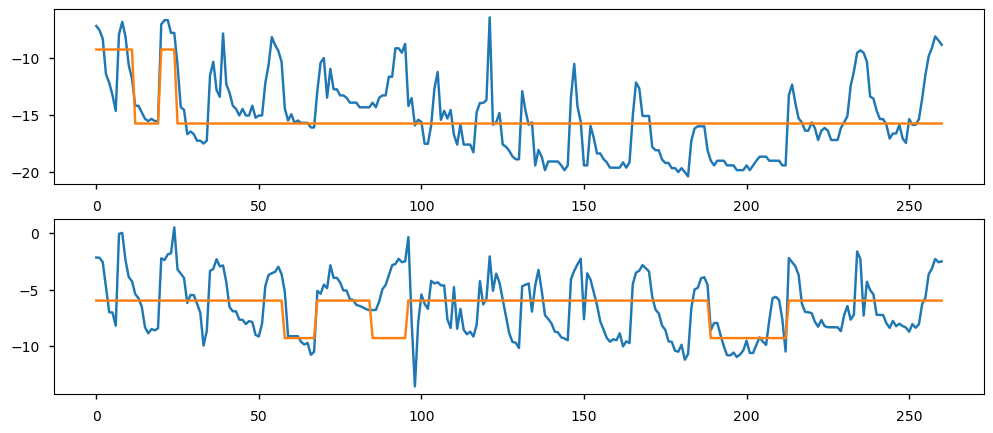

In [23]:
# THIS USES THE EXACT UPPER AND LOWER PARMEAN PREDICTIONS
# It also uses decision depth = 4 for lower light, and depth = 3 for upper light

#index = np.logical_and(np.logical_and(PARMEAN0.squeeze() >= -3, HOURS.squeeze() < 23.9), ERA5.squeeze() > -3.0)
index = np.logical_and(np.logical_and(HOURS.squeeze() >= 0.1 ,HOURS.squeeze() < 23.9), ERA5.squeeze() > 0.0)
MIDDLE_ylowerlight = np.array(LOWERPARMEAN)[index]
MIDDLE_yupperlight = np.array(UPPERLIGHT)[index]

MIDDLE_nlowerlight = MIDDLE_ylowerlight.shape[0]

XmiddleDAY = np.zeros((MIDDLE_nlowerlight,4)) 
XmiddleDAY[:,0] = FOOD.squeeze()[index]
XmiddleDAY[:,1] = ERA5.squeeze()[index]
XmiddleDAY[:,2] = HOURS.squeeze()[index]
XmiddleDAY[:,3] = PARMEAN0.squeeze()[index]

indexes = np.concatenate([np.arange(i, min(i+24, len(XmiddleDAY[:,0]))) for i in range(0, len(XmiddleDAY[:,0]), 48)])

MIDDLE_XLowerlightTrain = XmiddleDAY[indexes,:]
MIDDLE_yLowerlightTrain = MIDDLE_ylowerlight[indexes]
MIDDLE_XUpperlightTrain = XmiddleDAY[indexes,:]
MIDDLE_yUpperlightTrain = MIDDLE_yupperlight[indexes]

mask = ~np.isnan(MIDDLE_XLowerlightTrain).any(axis=1) & ~np.isnan(MIDDLE_yLowerlightTrain)
MIDDLE_XLowerlightTrain = MIDDLE_XLowerlightTrain[mask]
MIDDLE_yLowerlightTrain = MIDDLE_yLowerlightTrain[mask]
mask = ~np.isnan(MIDDLE_XUpperlightTrain).any(axis=1) & ~np.isnan(MIDDLE_yUpperlightTrain)
MIDDLE_XUpperlightTrain = MIDDLE_XUpperlightTrain[mask]
MIDDLE_yUpperlightTrain = MIDDLE_yUpperlightTrain[mask]

n = 1
MIDDLEmodelLowerlightDecisionTree = DecisionTreeRegressor(max_depth=n)
MIDDLEmodelLowerlightDecisionTree.fit(MIDDLE_XLowerlightTrain, MIDDLE_yLowerlightTrain)
n = 1
MIDDLEmodelUpperlightDecisionTree = DecisionTreeRegressor(max_depth=n)
MIDDLEmodelUpperlightDecisionTree.fit(MIDDLE_XUpperlightTrain, MIDDLE_yUpperlightTrain)

from sklearn.tree import export_text
import pandas as pd
XmiddleDAY_df = pd.DataFrame(XmiddleDAY, columns=feature_names)
tree_rules = export_text(MIDDLEmodelLowerlightDecisionTree, feature_names=list(XmiddleDAY_df.columns),max_depth=n)
print('Lowerlight Rules')
print(tree_rules)
tree_rules = export_text(MIDDLEmodelUpperlightDecisionTree, feature_names=list(XmiddleDAY_df.columns),max_depth=n)
print('Upperlight Rules')
print(tree_rules)

print('LOWERLIGHT')
for name,coef in zip(feature_names,MIDDLEmodelLowerlightDecisionTree.feature_importances_):
    print(name,coef)
print('UPPERLIGHT')
for name,coef in zip(feature_names,MIDDLEmodelUpperlightDecisionTree.feature_importances_):
    print(name,coef)

MIDDLEyLowerlightPredictDecisionTree = np.nan*np.ones_like(MIDDLE_ylowerlight)
MIDDLEyUpperlightPredictDecisionTree = np.nan*np.ones_like(MIDDLE_yupperlight)

maskall = ~np.isnan(XmiddleDAY).any(axis=1) & ~np.isnan(MIDDLE_ylowerlight)
MIDDLEyLowerlightPredictDecisionTree[maskall] = MIDDLEmodelLowerlightDecisionTree.predict(XmiddleDAY[maskall])
maskall = ~np.isnan(XmiddleDAY).any(axis=1) & ~np.isnan(MIDDLE_yupperlight)
MIDDLEyUpperlightPredictDecisionTree[maskall] = MIDDLEmodelUpperlightDecisionTree.predict(XmiddleDAY[maskall])


fig, ax = plt.subplots(2,figsize=(12,5))
ax[0].plot(MIDDLE_ylowerlight)
ax[0].plot(MIDDLEyLowerlightPredictDecisionTree)
ax[1].plot(MIDDLE_yupperlight)
ax[1].plot(MIDDLEyUpperlightPredictDecisionTree)

### Below is nighttime

[False False False ... False False False]
|--- food <= 17.33
|   |--- value: [-12.72]
|--- food >  17.33
|   |--- value: [-15.94]

PARMEAN
food 1.0
era5 0.0
hours 0.0
parmean0 0.0


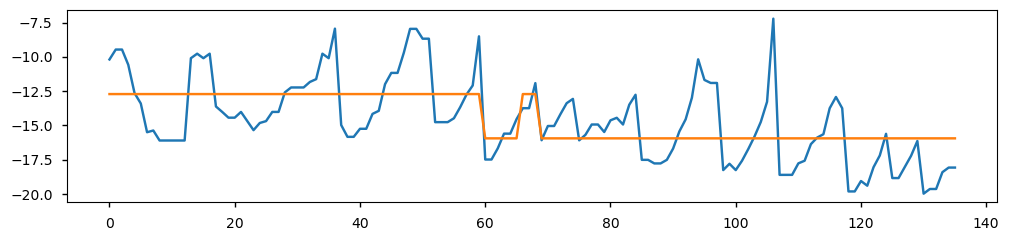

In [24]:
#index = np.logical_and(np.logical_and(PARMEAN0.squeeze() >= -3.0, HOURS.squeeze() < 23.9), ERA5.squeeze() < -3.0)
index = np.logical_and(np.logical_and(HOURS.squeeze() >= 0.1 ,HOURS.squeeze() < 23.9), ERA5.squeeze() <= 0.0)
print(index)
MIDDLE_yparmean = np.array(LOWERPARMEAN)[index]

MIDDLE_nparmean = MIDDLE_yparmean.shape[0]

XmiddleNIGHT = np.zeros((MIDDLE_nparmean,4)) 
XmiddleNIGHT[:,0] = FOOD.squeeze()[index]
XmiddleNIGHT[:,1] = ERA5.squeeze()[index]
XmiddleNIGHT[:,2] = HOURS.squeeze()[index]
XmiddleNIGHT[:,3] = PARMEAN0.squeeze()[index]

indexes = np.concatenate([np.arange(i, min(i+24, len(XmiddleNIGHT[:,0]))) for i in range(0, len(XmiddleNIGHT[:,0]), 48)])

MIDDLE_XParmeantrain = XmiddleNIGHT[indexes,:]
MIDDLE_yParmeanTrain = MIDDLE_yparmean[indexes]

mask = ~np.isnan(MIDDLE_XParmeantrain).any(axis=1) & ~np.isnan(MIDDLE_yParmeanTrain)
MIDDLE_XParmeantrain = MIDDLE_XParmeantrain[mask]
MIDDLE_yParmeanTrain = MIDDLE_yParmeanTrain[mask]

n = 1
modelParmeanDecisionTree = DecisionTreeRegressor(max_depth=n)
modelParmeanDecisionTree.fit(MIDDLE_XParmeantrain, MIDDLE_yParmeanTrain)

from sklearn.tree import export_text
import pandas as pd
XmiddleNIGHT_df = pd.DataFrame(XmiddleNIGHT, columns=feature_names)
tree_rules = export_text(modelParmeanDecisionTree, feature_names=list(XmiddleNIGHT_df.columns),max_depth=n)
print(tree_rules)

print('PARMEAN')
for name,coef in zip(feature_names,modelParmeanDecisionTree.feature_importances_):
    print(name,coef)

yParmeanPredictDecisionTree = np.nan*np.ones_like(MIDDLE_yparmean)

maskall = ~np.isnan(XmiddleNIGHT).any(axis=1) & ~np.isnan(MIDDLE_yparmean)
yParmeanPredictDecisionTree[maskall] = modelParmeanDecisionTree.predict(XmiddleNIGHT[maskall])

fig, ax = plt.subplots(1,figsize=(12,2.5))
ax.plot(MIDDLE_yparmean)
ax.plot(yParmeanPredictDecisionTree)